<a href="https://colab.research.google.com/github/claudio1975/Generative_Modelling/blob/main/Synthetic_Data_with_CDF_D1_D2_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Prepare Workspace

In [1]:
! pip install shap &> /dev/null

In [2]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from keras import layers, Model,Input
from tensorflow.keras.layers import Concatenate
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import subplots
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, make_scorer
from scipy.stats import ks_2samp
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
import umap
from sklearn.linear_model import TweedieRegressor
#from sklearn.model_selection import cross_val_score
#from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
import shap
from sklearn.mixture import GaussianMixture

import warnings
warnings.filterwarnings('ignore')

In [3]:
DEFAULT_RANDOM_SEED = 0 # Set a random seed for reproducibility throughout Python, NumPy, and TensorFlow operations
random.seed(DEFAULT_RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(DEFAULT_RANDOM_SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
np.random.seed(DEFAULT_RANDOM_SEED)
tf.random.set_seed(DEFAULT_RANDOM_SEED)

### Functions

In [4]:
def compare_real_vs_synthetic(real_df, synthetic_df, columns=None, kind='hist', bins=30, figsize=(15, 10)):
    """
    Compare distributions between real and synthetic datasets.

    Parameters:
    - real_df: pd.DataFrame, the original dataset
    - synthetic_df: pd.DataFrame, the synthetic dataset
    - columns: list of column names to compare; if None, all columns are used
    - kind: str, type of plot: 'hist', 'kde', or 'box'
    - bins: int, number of bins for histograms
    - figsize: tuple, size of the plot figure

    Returns:
    - None (displays plots)
    """
    if columns is None:
        columns = [col for col in real_df.columns if real_df[col].dtype != 'object']

    n_cols = 2
    n_rows = (len(columns) + 1) // n_cols

    plt.figure(figsize=figsize)

    for idx, col in enumerate(columns, 1):
        plt.subplot(n_rows, n_cols, idx)

        if kind == 'hist':
            sns.histplot(real_df[col], color='blue', label='Real', kde=False, stat='density', bins=bins, alpha=0.6)
            sns.histplot(synthetic_df[col], color='red', label='Synthetic', kde=False, stat='density', bins=bins, alpha=0.6)

        elif kind == 'kde':
            sns.kdeplot(real_df[col], color='blue', label='Real')
            sns.kdeplot(synthetic_df[col], color='red', label='Synthetic')

        elif kind == 'box':
            sns.boxplot(data=[real_df[col], synthetic_df[col]], palette=['blue', 'red'])
            plt.xticks([0, 1], ['Real', 'Synthetic'])

        else:
            raise ValueError("Unsupported plot kind. Choose from 'hist', 'kde', or 'box'.")

        plt.title(f"Comparison for '{col}'")
        plt.legend()

    plt.tight_layout()
    plt.show()


In [5]:
def pca_visual_comparison_3d(real_df, synthetic_df, color_by=None, title_suffix=""):
    """
    Compare real vs synthetic datasets using 3D PCA projection.

    Parameters:
    - real_df: pd.DataFrame, the original dataset
    - synthetic_df: pd.DataFrame, the synthetic dataset
    - color_by: str, optional column name for coloring points (must exist in both datasets)
    - title_suffix: str, suffix to append to plot title

    Returns:
    - None (displays PCA 3D scatter plot)
    """
    assert set(real_df.columns) == set(synthetic_df.columns), "Datasets must have the same columns."

    # Combine for joint scaling
    combined_df = pd.concat([real_df, synthetic_df])
    features = combined_df.drop(columns=[color_by]) if color_by else combined_df
    scaler = StandardScaler()
    combined_scaled = scaler.fit_transform(features)

    # Fit PCA (3 components for 3D)
    pca = PCA(n_components=3)
    pca_result = pca.fit_transform(combined_scaled)

    # Separate PCA results
    n_real = len(real_df)
    real_pca = pca_result[:n_real]
    synth_pca = pca_result[n_real:]

    # Prepare figure
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot real data
    ax.scatter(real_pca[:, 0], real_pca[:, 1], real_pca[:, 2],
               c='blue', label='Real', s=40, alpha=0.6, edgecolor='k')

    # Plot synthetic data
    ax.scatter(synth_pca[:, 0], synth_pca[:, 1], synth_pca[:, 2],
               c='red', label='Synthetic', s=40, alpha=0.6, edgecolor='k')

    ax.set_title(f"3D PCA: Real vs. Synthetic {title_suffix}", fontsize=12, weight='bold')
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")

    ax.grid(False)
    ax.legend()
    plt.tight_layout()
    plt.show()


In [6]:
def pca_visual_comparison(real_df, synthetic_df, n_components=2, color_by=None, title_suffix=""):
    """
    Compare real vs synthetic datasets using PCA projection.

    Parameters:
    - real_df: pd.DataFrame, the original dataset
    - synthetic_df: pd.DataFrame, the synthetic dataset
    - n_components: int, number of PCA dimensions (typically 2 or 3)
    - color_by: str, optional column name for coloring points (must exist in both datasets)
    - title_suffix: str, suffix to append to plot title

    Returns:
    - None (displays PCA scatter plot)
    """
    assert set(real_df.columns) == set(synthetic_df.columns), "Datasets must have the same columns."

    # Combine for joint scaling
    combined_df = pd.concat([real_df, synthetic_df])
    scaler = StandardScaler()
    combined_scaled = scaler.fit_transform(combined_df.drop(columns=[color_by]) if color_by else combined_df)

    # Fit PCA
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(combined_scaled)

    # Separate PCA results
    n_real = len(real_df)
    real_pca = pca_result[:n_real]
    synth_pca = pca_result[n_real:]

    # Create DataFrame for plotting
    df_plot = pd.DataFrame({
        'PC1': pca_result[:, 0],
        'PC2': pca_result[:, 1],
        'Source': ['Real'] * n_real + ['Synthetic'] * len(synthetic_df)
    })

    if color_by and color_by in real_df.columns:
        df_plot[color_by] = list(real_df[color_by]) + list(synthetic_df[color_by])

    # Plot
    plt.figure(figsize=(10, 7))
    sns.scatterplot(
        data=df_plot,
        x='PC1', y='PC2',
        hue='Source',
        style='Source',
        alpha=0.6,
        palette={'Real': 'blue', 'Synthetic': 'red'}
    )

    plt.title(f"PCA Projection: Real vs. Synthetic {title_suffix}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [7]:
def umap_visual_comparison_3d(real_df, synthetic_df, n_neighbors=15, min_dist=0.1, metric='euclidean', color_by=None, title_suffix=""):
    """
    Compare real vs synthetic datasets using 3D UMAP projection.

    Parameters:
    - real_df: pd.DataFrame, the original dataset
    - synthetic_df: pd.DataFrame, the synthetic dataset
    - color_by: str, optional column name for color grouping
    - title_suffix: str, optional title suffix

    Returns:
    - None
    """
    assert set(real_df.columns) == set(synthetic_df.columns), "Datasets must have the same columns."

    # Combine datasets for scaling
    combined_df = pd.concat([real_df, synthetic_df])
    if color_by and color_by in combined_df.columns:
        features = combined_df.drop(columns=[color_by])
    else:
        features = combined_df

    # Normalize features
    scaler = StandardScaler()
    combined_scaled = scaler.fit_transform(features)

    # UMAP transformation
    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=3,
        metric=metric,
        random_state=42
    )
    umap_result = reducer.fit_transform(combined_scaled)

    # Separate results
    n_real = len(real_df)
    real_umap = umap_result[:n_real]
    synth_umap = umap_result[n_real:]

    # Plotting
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot real and synthetic points and store the artists
    real_plot = ax.scatter(real_umap[:, 0], real_umap[:, 1], real_umap[:, 2],
                           c='blue', s=40, alpha=0.6, edgecolor='k', label='Real')

    synth_plot = ax.scatter(synth_umap[:, 0], synth_umap[:, 1], synth_umap[:, 2],
                            c='red', s=40, alpha=0.6, edgecolor='k', label='Synthetic')

    # Titles and labels
    ax.set_title(f"3D UMAP: Real vs. Synthetic {title_suffix}", fontsize=12, weight='bold')
    ax.set_xlabel("UMAP1")
    ax.set_ylabel("UMAP2")
    ax.set_zlabel("UMAP3")

    # Manual legend
    ax.legend(loc='best')

    plt.tight_layout()
    plt.show()


In [8]:
def umap_visual_comparison(real_df, synthetic_df, n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', color_by=None, title_suffix=""):
    """
    Compare real vs synthetic datasets using UMAP projection.
    """
    assert set(real_df.columns) == set(synthetic_df.columns), "Datasets must have the same columns."

    # Combine for joint scaling
    combined_df = pd.concat([real_df, synthetic_df])
    if color_by and color_by in combined_df.columns:
        combined_features = combined_df.drop(columns=[color_by])
    else:
        combined_features = combined_df

    # Normalize
    scaler = StandardScaler()
    combined_scaled = scaler.fit_transform(combined_features)

    # Apply UMAP
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components, metric=metric, random_state=42)
    umap_result = reducer.fit_transform(combined_scaled)

    # Build DataFrame for plotting
    n_real = len(real_df)
    df_plot = pd.DataFrame({
        'UMAP1': umap_result[:, 0],
        'UMAP2': umap_result[:, 1],
        'Source': ['Real'] * n_real + ['Synthetic'] * len(synthetic_df)
    })

    if color_by and color_by in real_df.columns:
        df_plot[color_by] = list(real_df[color_by]) + list(synthetic_df[color_by])

    # Plotting step
    plt.figure(figsize=(10, 7))
    sns.scatterplot(
        data=df_plot,
        x='UMAP1', y='UMAP2',
        hue='Source',
        style='Source',
        alpha=0.6,
        palette={'Real': 'blue', 'Synthetic': 'red'}
    )
    plt.title(f"UMAP Projection: Real vs. Synthetic {title_suffix}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [9]:
def run_glm_frequency_analysis(
    X_train, X_test, model=None, clip_exposure=False, random_state=0, label="Model"
):
    """
    Run GLM Poisson regression frequency analysis (ClaimNb ~ Features | Exposure).

    Parameters:
    - X_train: pd.DataFrame with ['Exposure', 'ClaimNb', ...]
    - X_test: pd.DataFrame with ['Exposure', 'ClaimNb', ...]
    - model: sklearn regressor, default is TweedieRegressor(power=1, link='log')
    - clip_exposure: bool, if True, caps Exposure at 1 in training set
    - random_state: int, for reproducibility
    - label: str, label for printing/logging

    Returns:
    - trained_model: fitted model
    - results: dict with CV scores, deviance on train/test, and predictions
    """

    np.random.seed(0)

    # Optionally clip exposure in training data
    if clip_exposure:
        X_train = X_train.copy()
        X_train['Exposure'] = np.where(X_train['Exposure'] > 1, 1, X_train['Exposure'])

    # Filter for Exposure > 0
    mask_tr = X_train['Exposure'] > 0
    mask_te = X_test['Exposure'] > 0
    X_train_f = X_train[mask_tr].copy()
    X_test_f = X_test[mask_te].copy()

    y_train = X_train_f['ClaimNb']
    y_test = X_test_f['ClaimNb']
    exposure_train = X_train_f['Exposure']
    exposure_test = X_test_f['Exposure']

    X_train_ = X_train_f.drop(['Exposure', 'ClaimNb', 'ClaimAmount'], axis=1, errors='ignore')
    X_test_ = X_test_f.drop(['Exposure', 'ClaimNb', 'ClaimAmount'], axis=1, errors='ignore')

    # Set model if not passed
    if model is None:
        model = TweedieRegressor(power=1, link='log')

    # Cross-validation
    cv = KFold(n_splits=5)
    mpd_scores = []

    for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X_train_)):
        X_tr, X_val = X_train_.iloc[train_idx], X_train_.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        w_tr, w_val = exposure_train.iloc[train_idx], exposure_train.iloc[val_idx]

        model.fit(X_tr, y_tr / w_tr, sample_weight=w_tr)
        y_pred = model.predict(X_val)

        score = mean_poisson_deviance(y_val / w_val, y_pred)
        print(f"Fold {fold_idx + 1} Poisson Deviance Score: {score:.4f}")
        mpd_scores.append(score)

    print(f"Average cross-validation Poisson Deviance Score: {np.mean(mpd_scores):.4f}")
    print(f"Standard Deviation of CV Scores: {np.std(mpd_scores):.4f}")

    # Final fit on full training set
    model.fit(X_train_, y_train / exposure_train, sample_weight=exposure_train)

    pred_train = model.predict(X_train_)
    pred_test = model.predict(X_test_)

    mpd_train = mean_poisson_deviance(y_train / exposure_train, pred_train)
    mpd_test = mean_poisson_deviance(y_test / exposure_test, pred_test)

    print(f"Train Poisson Deviance: {mpd_train:.4f}")
    print(f"Test Poisson Deviance: {mpd_test:.4f}")

    return model, {
        "cv_scores": mpd_scores,
        "mpd_train": mpd_train,
        "mpd_test": mpd_test,
        "train_predictions": pred_train,
        "test_predictions": pred_test
    }


In [10]:
def run_glm_cost_analysis(X_train, X_test, is_sampled=False, verbose=True):
    """
    Perform GLM Cost Analysis using Tweedie Regressor (power=2, link='log').

    Parameters:
    - X_train: Training DataFrame (must include 'ClaimAmount', 'ClaimNb', 'Exposure')
    - X_test: Testing DataFrame
    - is_sampled: If True, cap 'Exposure' at 1 for training data
    - verbose: If True, print CV results and scores

    Returns:
    - Dictionary containing train/test gamma deviance and predictions
    """
    np.random.seed(0)

    # Cap exposure if sampled
    if is_sampled:
        X_train = X_train.copy()
        X_train['Exposure'] = np.where(X_train['Exposure'] > 1, 1, X_train['Exposure'])

    X_train_co = X_train.copy()
    X_test_co = X_test.copy()

    # Compute average cost per claim (Acost)
    X_train_co['Acost'] = np.where(X_train_co['ClaimNb'] != 0,
                                   X_train_co['ClaimAmount'] / X_train_co['ClaimNb'], 0)
    X_test_co['Acost'] = np.where(X_test_co['ClaimNb'] != 0,
                                  X_test_co['ClaimAmount'] / X_test_co['ClaimNb'], 0)

    # Filter rows with non-zero claim amounts
    X_train_cost = X_train_co[X_train_co['ClaimAmount'] != 0].copy()
    X_test_cost = X_test_co[X_test_co['ClaimAmount'] != 0].copy()

    # Target and weights
    y_train = X_train_cost['Acost']
    claim_tr = X_train_cost['ClaimNb']
    y_test = X_test_cost['Acost']
    claim_te = X_test_cost['ClaimNb']

    # Features
    drop_cols = ['Acost', 'Exposure', 'ClaimAmount', 'ClaimNb']
    X_train_ = X_train_cost.drop(columns=drop_cols)
    X_test_ = X_test_cost.drop(columns=drop_cols)

    # Initialize model
    glm_cl = TweedieRegressor(power=2, link='log')

    # Cross-validation
    cv = KFold(n_splits=5, shuffle=True, random_state=0)
    mgd_scores = []

    for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X_train_)):
        X_tr, X_val = X_train_.iloc[train_idx], X_train_.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        w_tr, w_val = claim_tr.iloc[train_idx], claim_tr.iloc[val_idx]

        glm_cl.fit(X_tr, y_tr, sample_weight=w_tr)
        y_pred_val = glm_cl.predict(X_val)
        score = mean_gamma_deviance(y_val, y_pred_val)
        mgd_scores.append(score)

        if verbose:
            print(f"Fold {fold_idx + 1} Gamma Deviance Score: {score:.4f}")

    if verbose:
        print("Average cross-validation Gamma Deviance Score:", np.mean(mgd_scores))
        print("Standard Deviation of CV Scores:", np.std(mgd_scores))

    # Train on full data
    glm_cl.fit(X_train_, y_train, sample_weight=claim_tr)

    # Predictions
    y_pred_train = glm_cl.predict(X_train_)
    y_pred_test = glm_cl.predict(X_test_)

    # Deviance on train and test
    mgd_train = mean_gamma_deviance(y_train, y_pred_train)
    mgd_test = mean_gamma_deviance(y_test, y_pred_test)

    if verbose:
        print(f"Train Gamma Deviance: {mgd_train:.4f}")
        print(f"Test Gamma Deviance: {mgd_test:.4f}")

    return {
        "cv_scores": mgd_scores,
        'mgd_train': mgd_train,
        'mgd_test': mgd_test,
        'y_pred_train': y_pred_train,
        'y_pred_test': y_pred_test
    }


In [11]:
def plot_glm_shap_importance(
    X_train, X_test, y_train, sample_weight,
    power: int, title: str, max_display: int = 10, figsize: tuple = (5, 5), seed: int = 0
):
    """
    Compute and plot SHAP feature importance for GLMs using SHAP LinearExplainer.

    Parameters:
        X_train (pd.DataFrame): Training features
        X_test (pd.DataFrame): Test features
        y_train (pd.Series or np.array): Training target
        sample_weight (pd.Series or np.array): Sample weights
        power (int): Tweedie power (1 = Poisson for frequency, 2 = Gamma for severity)
        title (str): Title for the plot
        max_display (int): Max number of features to display
        figsize (tuple): Size of the figure
        seed (int): Random seed for reproducibility
    """
    np.random.seed(seed)

    model = TweedieRegressor(power=power, link='log')
    model.fit(X_train, y_train, sample_weight=sample_weight)

    masker = shap.maskers.Independent(X_train)
    explainer = shap.LinearExplainer(model, masker=masker)
    shap_values = explainer.shap_values(X_test)

    plt.rcParams['figure.figsize'] = figsize
    shap.summary_plot(
        shap_values, features=X_test,
        feature_names=X_test.columns,
        plot_type='bar',
        max_display=max_display,
        show=False
    )
    plt.title(title, fontsize=12)
    plt.tight_layout()
    plt.show()


### Upload dataset and data handling

In [12]:
#-------------------
# D1
#-------------------
df1=pd.read_csv('/content/ausprivauto0405.csv')

In [13]:
print(df1.shape)

(67856, 9)


In [14]:
print(df1.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67856 entries, 0 to 67855
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Exposure     67856 non-null  float64
 1   VehValue     67856 non-null  float64
 2   VehAge       67856 non-null  object 
 3   VehBody      67856 non-null  object 
 4   Gender       67856 non-null  object 
 5   DrivAge      67856 non-null  object 
 6   ClaimOcc     67856 non-null  int64  
 7   ClaimNb      67856 non-null  int64  
 8   ClaimAmount  67856 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 4.7+ MB
None


In [15]:
print(df1.columns)

Index(['Exposure', 'VehValue', 'VehAge', 'VehBody', 'Gender', 'DrivAge',
       'ClaimOcc', 'ClaimNb', 'ClaimAmount'],
      dtype='object')


In [16]:
df1.head()

,Exposure,VehValue,VehAge,VehBody,Gender,DrivAge,ClaimOcc,ClaimNb,ClaimAmount
0,0.303901,1.06,old cars,Hatchback,Female,young people,0,0,0.0
1,0.648871,1.03,young cars,Hatchback,Female,older work. people,0,0,0.0
2,0.569473,3.26,young cars,Utility,Female,young people,0,0,0.0
3,0.317591,4.14,young cars,Station wagon,Female,young people,0,0,0.0
4,0.648871,0.72,oldest cars,Hatchback,Female,young people,0,0,0.0


In [17]:
df1_duplicated_rows=df1[df1.duplicated()]
df1_duplicated_rows

,Exposure,VehValue,VehAge,VehBody,Gender,DrivAge,ClaimOcc,ClaimNb,ClaimAmount
63,0.095825,2.650,youngest cars,Sedan,Female,working people,0,0,0.0
152,0.616016,0.450,oldest cars,Hatchback,Female,oldest people,0,0,0.0
1003,0.002738,3.170,youngest cars,Utility,Male,youngest people,0,0,0.0
1031,0.848734,4.700,youngest cars,Station wagon,Female,young people,0,0,0.0
1165,0.903491,1.280,oldest cars,Station wagon,Male,oldest people,0,0,0.0
...,...,...,...,...,...,...,...,...,...
67769,0.251882,0.980,old cars,Sedan,Female,old people,0,0,0.0
67779,0.851472,5.236,youngest cars,Station wagon,Female,older work. people,0,0,0.0
67796,0.908966,2.440,youngest cars,Sedan,Female,old people,0,0,0.0
67811,0.769336,1.200,old cars,Sedan,Male,youngest people,0,0,0.0


In [18]:
df1=df1.drop_duplicates()

In [19]:
df1_duplicated_col=df1.columns[df1.columns.duplicated()]
df1_duplicated_col

Index([], dtype='object')

In [20]:
missing=df1.isnull().sum()/df1.shape[0]*100
missing

,0
Exposure,0.0
VehValue,0.0
VehAge,0.0
VehBody,0.0
Gender,0.0
DrivAge,0.0
ClaimOcc,0.0
ClaimNb,0.0
ClaimAmount,0.0


### Encoding

In [21]:
print(df1['VehAge'].unique())
print(df1['DrivAge'].unique())
print(df1['VehBody'].unique())
print(df1['Gender'].unique())


['old cars' 'young cars' 'oldest cars' 'youngest cars']
['young people' 'older work. people' 'oldest people' 'working people'
 'old people' 'youngest people']
['Hatchback' 'Utility' 'Station wagon' 'Hardtop' 'Panel van' 'Sedan'
 'Truck' 'Coupe' 'Minibus' 'Motorized caravan' 'Bus' 'Convertible'
 'Roadster']
['Female' 'Male']


In [22]:
df1_encod=df1.copy()
# VehAge
VehAge_group = {'old cars':'1','young cars':'2','oldest cars':'3','youngest cars':'4'}
df1_encod['VehAge'] = df1_encod['VehAge'].map(VehAge_group)
df1_encod['VehAge']= df1_encod['VehAge'].astype(int)
# DrivAge
DrivAge_group = {'young people':'1','older work. people':'2','oldest people':'3','working people':'4','old people':'5','youngest people':'6'}
df1_encod['DrivAge'] = df1_encod['DrivAge'].map(DrivAge_group)
df1_encod['DrivAge']= df1_encod['DrivAge'].astype(int)
# VehBody
VehBody_group = {'Hatchback':'1','Utility':'2','Station wagon':'3','Hardtop':'4','Panel van':'5','Sedan':'6','Truck':'7',\
                'Coupe':'8', 'Minibus':'9', 'Motorized caravan':'10', 'Bus':'11', 'Convertible':'12','Roadster':'13'}
df1_encod['VehBody'] = df1_encod['VehBody'].map(VehBody_group)
df1_encod['VehBody']= df1_encod['VehBody'].astype(int)
# Gender
Gender_group = {'Female':'0','Male':'1'}
df1_encod['Gender'] = df1_encod['Gender'].map(Gender_group)
df1_encod['Gender']= df1_encod['Gender'].astype(int)




In [23]:
df1_encod.head()

,Exposure,VehValue,VehAge,VehBody,Gender,DrivAge,ClaimOcc,ClaimNb,ClaimAmount
0,0.303901,1.06,1,1,0,1,0,0,0.0
1,0.648871,1.03,2,1,0,2,0,0,0.0
2,0.569473,3.26,2,2,0,1,0,0,0.0
3,0.317591,4.14,2,3,0,1,0,0,0.0
4,0.648871,0.72,3,1,0,1,0,0,0.0


### Split dataset

In [24]:
# Split the dataset into train/test split
X_train, X_test = train_test_split(df1_encod, test_size=0.2, random_state=0)

In [25]:
X_train.shape

(53320, 9)

### Build a CDF

In [26]:
## Data Preparation
# Set random seeds for reproducibility
np.random.seed(0)
tf.random.set_seed(0)

# Define columns
condition_col = 'ClaimOcc'          # Binary condition
target_discrete = 'ClaimNb'         # Discrete variable
target_continuous = 'ClaimAmount'   # Continuous variable

# Define features to include 'ClaimNb' and 'ClaimAmount' and exclude 'ClaimOcc'
features = [col for col in X_train.columns if col != condition_col]

# Extract features and condition, ensuring float32 data type
X_features = X_train[features].values.astype(np.float32)        # Ensure float32
X_condition = X_train[condition_col].values.reshape(-1, 1).astype(np.float32)  # Ensure float32

# Normalize all features using standard normalization
means = np.mean(X_features, axis=0).astype(np.float32)
stds = np.std(X_features, axis=0).astype(np.float32)
# To avoid division by zero
stds_corrected = np.where(stds == 0, 1, stds).astype(np.float32)
X_features_normalized = (X_features - means) / stds_corrected
X_features_normalized = X_features_normalized.astype(np.float32)  # Ensure float32

# Prepare the input for the diffusion model (features + condition)
X_input = np.concatenate([X_features_normalized, X_condition], axis=1).astype(np.float32)  # Ensure float32

# Define dimensions
input_dim = X_input.shape[1]        # Number of features + condition
condition_dim = 1                   # Since ClaimOcc is binary

print(f"Shape of X_input: {X_input.shape}")

## Define diffusion process
class DiffusionModel:
    def __init__(self, input_dim, timesteps=1000, beta_start=1e-4, beta_end=0.02):
        self.input_dim = input_dim
        self.timesteps = timesteps

        # Linear beta schedule with float32
        self.beta = np.linspace(beta_start, beta_end, timesteps, dtype=np.float32)
        self.alpha = 1.0 - self.beta
        self.alpha_cumprod = np.cumprod(self.alpha).astype(np.float32)
        self.alpha_cumprod_prev = np.concatenate(
            (np.array([1.0], dtype=np.float32), self.alpha_cumprod[:-1])
        ).astype(np.float32)

    def q_sample(self, x_start, t, noise=None):
        if noise is None:
            noise = tf.random.normal(shape=x_start.shape, dtype=tf.float32)  # Ensure float32
        # Convert alpha_cumprod to float32 tensors
        alpha_cumprod = tf.constant(self.alpha_cumprod, dtype=tf.float32)
        one = tf.constant(1.0, dtype=tf.float32)

        sqrt_alpha_cumprod = tf.gather(alpha_cumprod, t)[:, None]
        sqrt_one_minus_alpha_cumprod = tf.gather(one - alpha_cumprod, t)[:, None]
        return sqrt_alpha_cumprod * x_start + sqrt_one_minus_alpha_cumprod * noise

def build_unet(input_dim, condition_dim, timesteps=1000):
    """
    Builds a U-Net-like architecture for tabular data.

    Parameters:
    - input_dim: Dimension of the input features including condition
    - condition_dim: Dimension of the condition variable
    - timesteps: Number of diffusion timesteps

    Returns:
    - A Keras Model representing the U-Net denoising network
    """
    # Inputs
    x_input = layers.Input(shape=(input_dim,), dtype='float32', name='input_features')
    t_input = layers.Input(shape=(), dtype=tf.int32, name='timesteps')  # Timestep
    condition_input = layers.Input(shape=(condition_dim,), dtype='float32', name='condition')

    # Timestep Embedding
    t_embed = layers.Embedding(input_dim=timesteps, output_dim=64, dtype='float32')(t_input)
    t_embed = layers.Dense(64, activation='relu')(t_embed)
    t_embed = layers.Dense(64, activation='relu')(t_embed)

    # Concatenate all inputs
    x = layers.Concatenate()([x_input, condition_input, t_embed])

    # Encoder
    encoder_layer1 = layers.Dense(512, activation='relu')(x)
    encoder_layer2 = layers.Dense(512, activation='relu')(encoder_layer1)
    encoder_layer3 = layers.Dense(512, activation='relu')(encoder_layer2)

    # Bottleneck
    bottleneck = layers.Dense(512, activation='relu')(encoder_layer3)

    # Decoder
    decoder_layer1 = layers.Dense(512, activation='relu')(bottleneck)
    decoder_layer1 = layers.Concatenate()([decoder_layer1, encoder_layer3])  # Skip connection

    decoder_layer2 = layers.Dense(512, activation='relu')(decoder_layer1)
    decoder_layer2 = layers.Concatenate()([decoder_layer2, encoder_layer2])  # Skip connection

    decoder_layer3 = layers.Dense(512, activation='relu')(decoder_layer2)
    decoder_layer3 = layers.Concatenate()([decoder_layer3, encoder_layer1])  # Skip connection

    # Output
    output = layers.Dense(input_dim, activation='linear')(decoder_layer3)

    # Define the model
    model = Model(inputs=[x_input, t_input, condition_input], outputs=output, name='UNet_DiffusionModel')
    return model

# Start the U-Net denoising model
unet_model = build_unet(input_dim=input_dim, condition_dim=condition_dim, timesteps=1000)
unet_model.summary()

# Start the diffusion process
diffusion = DiffusionModel(input_dim=input_dim, timesteps=1000)

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Training parameters
batch_size = 128
epochs = 30
steps_per_epoch = X_input.shape[0] // batch_size

# Prepare TensorFlow dataset
dataset = tf.data.Dataset.from_tensor_slices((X_input, X_input[:, -condition_dim:]))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)

@tf.function
def train_step(x, condition):
    # Sample random timestep for each example in the batch
    t = tf.random.uniform(shape=(tf.shape(x)[0],), minval=0, maxval=1000, dtype=tf.int32)

    # Sample noise
    noise = tf.random.normal(shape=x.shape, dtype=tf.float32)  # Ensure float32

    # Get noised data
    x_noised = diffusion.q_sample(x, t, noise)

    with tf.GradientTape() as tape:
        # Predict the noise
        noise_pred = unet_model([x_noised, t, condition], training=True)
        # Compute loss
        loss = tf.reduce_mean(tf.square(noise - noise_pred))

    # Backpropagation
    gradients = tape.gradient(loss, unet_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, unet_model.trainable_variables))

    return loss

# Training loop
for epoch in range(epochs):
    epoch_loss = 0.0
    for step, (x_batch, condition_batch) in enumerate(tqdm(dataset, desc=f"Epoch {epoch + 1}/{epochs}")):
        loss = train_step(x_batch, condition_batch)
        epoch_loss += loss.numpy()
    epoch_loss /= steps_per_epoch
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}")

def sample_diffusion(model, diffusion, condition, num_samples):
    """
    Generates samples by reversing the diffusion process.

    Parameters:
    - model: The trained denoising model
    - diffusion: The diffusion process instance
    - condition: Condition tensor
    - num_samples: Number of samples to generate

    Returns:
    - Tensor containing generated samples
    """
    x = tf.random.normal(shape=(num_samples, diffusion.input_dim), dtype=tf.float32)  # Ensure float32
    for t in tqdm(range(diffusion.timesteps - 1, -1, -1), desc="Sampling"):
        t_tensor = tf.fill([num_samples], t)
        noise_pred = model([x, t_tensor, condition], training=False)

        beta_t = diffusion.beta[t]
        alpha_t = diffusion.alpha[t]
        alpha_cumprod_t = diffusion.alpha_cumprod[t]
        alpha_cumprod_prev_t = diffusion.alpha_cumprod_prev[t]

        # Convert to float32 tensors
        beta_t = tf.constant(beta_t, dtype=tf.float32)
        alpha_t = tf.constant(alpha_t, dtype=tf.float32)
        alpha_cumprod_t = tf.constant(alpha_cumprod_t, dtype=tf.float32)

        one = tf.constant(1.0, dtype=tf.float32)

        sqrt_alpha_t = tf.sqrt(alpha_t)
        inv_sqrt_alpha_t = one / sqrt_alpha_t

        one_minus_alpha_t = one - alpha_t
        sqrt_one_minus_alpha_cumprod_t = tf.sqrt(one - alpha_cumprod_t)
        inv_sqrt_one_minus_alpha_cumprod_t = one / sqrt_one_minus_alpha_cumprod_t

        # Compute x
        x = inv_sqrt_alpha_t * (x - (one_minus_alpha_t * inv_sqrt_one_minus_alpha_cumprod_t) * noise_pred)

        if t > 0:
            noise = tf.random.normal(shape=(num_samples, diffusion.input_dim), dtype=tf.float32)  # Ensure float32
            x = x + tf.sqrt(beta_t) * noise
    return x


Shape of X_input: (53320, 9)


Model: "UNet_DiffusionModel"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ timesteps           │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 64)        │     64,000 │ timesteps[0][0]   │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      4,160 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_features      │ (None, 9)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ condition           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      4,160 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 74)        │          0 │ input_features[0… │
│ (Concatenate)       │                   │            │ condition[0][0],  │
│                     │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 512)       │     38,400 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 512)       │    262,656 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 512)       │    262,656 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 512)       │    262,656 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 512)       │    262,656 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 1024)      │          0 │ dense_6[0][0],    │
│ (Concatenate)       │                   │            │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 512)       │    524,800 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 1024)      │          0 │ dense_7[0][0],    │
│ (Concatenate)       │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 512)       │    524,800 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 1024)      │          0 │ dense_8[0][0],    │
│ (Concatenate)       │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 9)         │      9,225 │ concatenate_3[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,220,169 (8.47 MB)

 Trainable params: 2,220,169 (8.47 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30: 100%|██████████| 417/417 [00:06<00:00, 60.02it/s] 


Epoch 1/30, Loss: 0.2706


Epoch 2/30: 100%|██████████| 417/417 [00:02<00:00, 175.75it/s]


Epoch 2/30, Loss: 0.2024


Epoch 3/30: 100%|██████████| 417/417 [00:02<00:00, 182.28it/s]


Epoch 3/30, Loss: 0.1889


Epoch 4/30: 100%|██████████| 417/417 [00:02<00:00, 177.40it/s]


Epoch 4/30, Loss: 0.1817


Epoch 5/30: 100%|██████████| 417/417 [00:02<00:00, 186.62it/s]


Epoch 5/30, Loss: 0.1767


Epoch 6/30: 100%|██████████| 417/417 [00:02<00:00, 191.28it/s]


Epoch 6/30, Loss: 0.1727


Epoch 7/30: 100%|██████████| 417/417 [00:02<00:00, 185.66it/s]


Epoch 7/30, Loss: 0.1679


Epoch 8/30: 100%|██████████| 417/417 [00:02<00:00, 192.29it/s]


Epoch 8/30, Loss: 0.1663


Epoch 9/30: 100%|██████████| 417/417 [00:02<00:00, 185.10it/s]


Epoch 9/30, Loss: 0.1656


Epoch 10/30: 100%|██████████| 417/417 [00:02<00:00, 191.16it/s]


Epoch 10/30, Loss: 0.1628


Epoch 11/30: 100%|██████████| 417/417 [00:02<00:00, 197.34it/s]


Epoch 11/30, Loss: 0.1618


Epoch 12/30: 100%|██████████| 417/417 [00:02<00:00, 194.53it/s]


Epoch 12/30, Loss: 0.1597


Epoch 13/30: 100%|██████████| 417/417 [00:02<00:00, 197.77it/s]


Epoch 13/30, Loss: 0.1580


Epoch 14/30: 100%|██████████| 417/417 [00:02<00:00, 195.85it/s]


Epoch 14/30, Loss: 0.1546


Epoch 15/30: 100%|██████████| 417/417 [00:02<00:00, 195.22it/s]


Epoch 15/30, Loss: 0.1570


Epoch 16/30: 100%|██████████| 417/417 [00:02<00:00, 198.13it/s]


Epoch 16/30, Loss: 0.1548


Epoch 17/30: 100%|██████████| 417/417 [00:02<00:00, 197.20it/s]


Epoch 17/30, Loss: 0.1524


Epoch 18/30: 100%|██████████| 417/417 [00:02<00:00, 195.32it/s]


Epoch 18/30, Loss: 0.1501


Epoch 19/30: 100%|██████████| 417/417 [00:02<00:00, 198.17it/s]


Epoch 19/30, Loss: 0.1505


Epoch 20/30: 100%|██████████| 417/417 [00:02<00:00, 196.93it/s]


Epoch 20/30, Loss: 0.1491


Epoch 21/30: 100%|██████████| 417/417 [00:02<00:00, 196.49it/s]


Epoch 21/30, Loss: 0.1503


Epoch 22/30: 100%|██████████| 417/417 [00:02<00:00, 197.35it/s]


Epoch 22/30, Loss: 0.1479


Epoch 23/30: 100%|██████████| 417/417 [00:02<00:00, 194.48it/s]


Epoch 23/30, Loss: 0.1464


Epoch 24/30: 100%|██████████| 417/417 [00:02<00:00, 194.82it/s]


Epoch 24/30, Loss: 0.1458


Epoch 25/30: 100%|██████████| 417/417 [00:02<00:00, 198.25it/s]


Epoch 25/30, Loss: 0.1453


Epoch 26/30: 100%|██████████| 417/417 [00:02<00:00, 198.27it/s]


Epoch 26/30, Loss: 0.1444


Epoch 27/30: 100%|██████████| 417/417 [00:02<00:00, 197.04it/s]


Epoch 27/30, Loss: 0.1427


Epoch 28/30: 100%|██████████| 417/417 [00:02<00:00, 198.52it/s]


Epoch 28/30, Loss: 0.1439


Epoch 29/30: 100%|██████████| 417/417 [00:02<00:00, 194.75it/s]


Epoch 29/30, Loss: 0.1433


Epoch 30/30: 100%|██████████| 417/417 [00:02<00:00, 200.83it/s]

Epoch 30/30, Loss: 0.1423


### Generate Samples

In [27]:
def generate_synthetic_data(model, diffusion, num_samples, claim_occ_value=0,
                            columns_to_round=None, exposure_mean=None,
                            min_claim_amount=None):
    """
    Generates synthetic data with specified ClaimOcc value, incorporating CVAE constraints.

    Parameters:
    - model: The trained denoising model (UNet)
    - diffusion: The diffusion process instance
    - num_samples: Number of samples to generate
    - claim_occ_value: Value of ClaimOcc to condition on (0 or 1)
    - columns_to_round: List of column names to round to nearest integer
    - exposure_mean: Mean value of 'Exposure' to replace zeros
    - min_claim_amount: Minimum value to enforce for 'ClaimAmount' when 'ClaimNb' > 0

    Returns:
    - DataFrame containing generated synthetic data
    """
    # Define conditions
    condition = np.full((num_samples, condition_dim), claim_occ_value).astype(np.float32)

    # Convert to tensor
    condition_tensor = tf.convert_to_tensor(condition, dtype=tf.float32)

    # Generate samples
    generated_noised = sample_diffusion(model, diffusion, condition_tensor, num_samples)

    # Convert to numpy array
    generated_noised = generated_noised.numpy()

    # Separate features and condition_col
    generated_features_noised = generated_noised[:, :-1]  # Assuming last column is condition_col

    # Rescale features to original scale
    generated_features = generated_features_noised * stds_corrected + means

    # Convert to DataFrame
    generated_data = pd.DataFrame(generated_features, columns=features)

    # Assign the condition variable
    generated_data[condition_col] = claim_occ_value

    # Handle discrete variables: 'ClaimNb'
    if target_discrete in features:
        claim_nb_idx = features.index(target_discrete)
        # Round 'ClaimNb' to the nearest integer
        generated_data[target_discrete] = np.round(generated_data[target_discrete]).astype(int)
    else:
        raise ValueError(f"Target discrete column '{target_discrete}' not found in features.")

    # Handle 'ClaimAmount' based on 'ClaimNb'
    if target_continuous in features:
        claim_amount_idx = features.index(target_continuous)
        generated_claim_nb = generated_data[target_discrete].values
        # Set 'ClaimAmount' to 0 where 'ClaimNb' is 0
        generated_data[target_continuous] = np.where(generated_claim_nb == 0, 0, generated_data[target_continuous])

        if min_claim_amount is not None:
            # Enforce minimum 'ClaimAmount' where 'ClaimNb' > 0
            generated_data[target_continuous] = np.where(
                generated_claim_nb > 0,
                generated_data[target_continuous].clip(lower=min_claim_amount),
                generated_data[target_continuous]
            )
    else:
        raise ValueError(f"Target continuous column '{target_continuous}' not found in features.")

    # Post-processing: Round Specific Columns and Clip Negative Values
    if columns_to_round is not None:
        # Check if these columns exist in the generated data
        missing_round_columns = [col for col in columns_to_round if col not in generated_data.columns]
        if missing_round_columns:
            raise ValueError(f"The following columns to round are missing in generated data: {missing_round_columns}")

        # Round the specified columns to nearest integer
        generated_data[columns_to_round] = generated_data[columns_to_round].round().astype(int)

    # Replace negative values with zero for all numerical columns
    numerical_cols = generated_data.select_dtypes(include=[np.number]).columns.tolist()
    generated_data[numerical_cols] = generated_data[numerical_cols].clip(lower=0)

    return generated_data

# Define CVAE-like constraints
columns_to_round = ['VehAge', 'DrivAge', 'VehBody', 'Gender']
min_claim_amount = X_train['ClaimAmount'].mean()

# Define generation parameters
num_samples = X_train.shape[0]
num_samples_claim0 = X_train[X_train['ClaimOcc']==0].shape[0]
num_samples_claim1 = num_samples - num_samples_claim0

# Generate samples with ClaimOcc=0
synthetic_data_claim0 = generate_synthetic_data(
    model=unet_model,
    diffusion=diffusion,
    num_samples=num_samples_claim0,
    claim_occ_value=0,
    columns_to_round=columns_to_round,
    min_claim_amount=min_claim_amount
)

# Generate samples with ClaimOcc=1
synthetic_data_claim1 = generate_synthetic_data(
    model=unet_model,
    diffusion=diffusion,
    num_samples=num_samples_claim1,
    claim_occ_value=1,
    columns_to_round=columns_to_round,
    min_claim_amount=min_claim_amount
)

# Combine the datasets
synthetic_data = pd.concat([synthetic_data_claim0, synthetic_data_claim1], ignore_index=True)

# Shuffle the dataset to mix ClaimOcc=0 and ClaimOcc=1 samples
synthetic_data = synthetic_data.sample(frac=1, random_state=0).reset_index(drop=True)



Sampling: 100%|██████████| 1000/1000 [00:18<00:00, 52.84it/s]


### Use Generate Samples Dataframe

In [28]:
new_samples_df=synthetic_data.copy()

### Data Comparison

In [29]:
X_train.head()

,Exposure,VehValue,VehAge,VehBody,Gender,DrivAge,ClaimOcc,ClaimNb,ClaimAmount
16112,0.621492,1.66,1,1,0,5,0,0,0.0
39849,0.676249,0.70,3,3,0,1,0,0,0.0
41557,0.257358,2.49,1,3,0,3,0,0,0.0
59930,0.654346,0.86,1,2,1,4,0,0,0.0
60224,0.637919,2.72,2,2,1,1,0,0,0.0


In [30]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Exposure,53320.0,0.466535,0.288448,0.002738,0.21629,0.443532,0.706366,0.999316
VehValue,53320.0,1.784108,1.217545,0.000000,1.01000,1.500000,2.160000,34.560000
VehAge,53320.0,2.346755,1.085962,1.000000,1.00000,2.000000,3.000000,4.000000
VehBody,53320.0,3.672824,2.260395,1.000000,1.00000,3.000000,6.000000,13.000000
Gender,53320.0,0.431152,0.495242,0.000000,0.00000,0.000000,1.000000,1.000000
DrivAge,53320.0,3.193323,1.610507,1.000000,2.00000,3.000000,4.000000,6.000000
ClaimOcc,53320.0,0.069449,0.254218,0.000000,0.00000,0.000000,0.000000,1.000000
ClaimNb,53320.0,0.074194,0.280946,0.000000,0.00000,0.000000,0.000000,4.000000
ClaimAmount,53320.0,136.092076,1004.945014,0.000000,0.00000,0.000000,0.000000,46868.179932


In [31]:
new_samples_df.head()

,Exposure,VehValue,VehAge,VehBody,Gender,DrivAge,ClaimNb,ClaimAmount,ClaimOcc
0,0.385780,0.931284,2,6,1,3,1,220.01413,1
1,0.331130,1.023429,3,2,1,5,0,0.00000,0
2,0.178278,1.285152,4,1,1,3,0,0.00000,0
3,0.000000,1.469963,3,1,1,1,0,0.00000,0
4,0.939176,1.540829,3,3,0,1,0,0.00000,0


In [32]:
new_samples_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Exposure,53320.0,0.427618,0.273067,0.0,0.200224,0.408881,0.637660,1.134487
VehValue,53320.0,1.767210,1.023709,0.0,1.055371,1.561312,2.231766,11.694516
VehAge,53320.0,2.363016,1.072141,1.0,1.000000,2.000000,3.000000,4.000000
VehBody,53320.0,3.541560,2.298501,0.0,1.000000,3.000000,6.000000,13.000000
Gender,53320.0,0.507596,0.499947,0.0,0.000000,1.000000,1.000000,1.000000
DrivAge,53320.0,3.128038,1.509629,1.0,2.000000,3.000000,4.000000,7.000000
ClaimNb,53320.0,0.069692,0.255586,0.0,0.000000,0.000000,0.000000,2.000000
ClaimAmount,53320.0,81.233528,480.980635,0.0,0.000000,0.000000,0.000000,16169.923828
ClaimOcc,53320.0,0.069449,0.254218,0.0,0.000000,0.000000,0.000000,1.000000


In [33]:
# Check for consistency
consistent_zeros = ((X_train["ClaimNb"] == 0) & (X_train["ClaimOcc"] == 0) & (X_train["ClaimAmount"] == 0)).sum()
consistent_positives = ((X_train["ClaimNb"] > 0) & (X_train["ClaimOcc"] > 0) & (X_train["ClaimAmount"] > 0)).sum()

# Display results
print(f"Records where all three are zero: {consistent_zeros}")
print(f"Records where all three are positive: {consistent_positives}")

Records where all three are zero: 49617
Records where all three are positive: 3703


In [34]:
# Check for consistency
consistent_zeros = ((new_samples_df["ClaimNb"] == 0) & (new_samples_df["ClaimOcc"] == 0) & (new_samples_df["ClaimAmount"] == 0)).sum()
consistent_positives = ((new_samples_df["ClaimNb"] > 0) & (new_samples_df["ClaimOcc"] > 0) & (new_samples_df["ClaimAmount"] > 0)).sum()

# Display results
print(f"Records where all three are zero: {consistent_zeros}")
print(f"Records where all three are positive: {consistent_positives}")

Records where all three are zero: 49617
Records where all three are positive: 3703


In [35]:
# Find inconsistencies
inconsistent_records = new_samples_df[
    ~(((new_samples_df["ClaimNb"] == 0) & (new_samples_df["ClaimOcc"] == 0) & (new_samples_df["ClaimAmount"] == 0)) |
      ((new_samples_df["ClaimNb"] > 0) & (new_samples_df["ClaimOcc"] > 0) & (new_samples_df["ClaimAmount"] > 0)))
]

print(f"Number of inconsistent records: {len(inconsistent_records)}")
print(inconsistent_records.head())  # Show a few inconsistent rows

Number of inconsistent records: 0
Empty DataFrame
Columns: [Exposure, VehValue, VehAge, VehBody, Gender, DrivAge, ClaimNb, ClaimAmount, ClaimOcc]
Index: []


### Visual Comparison

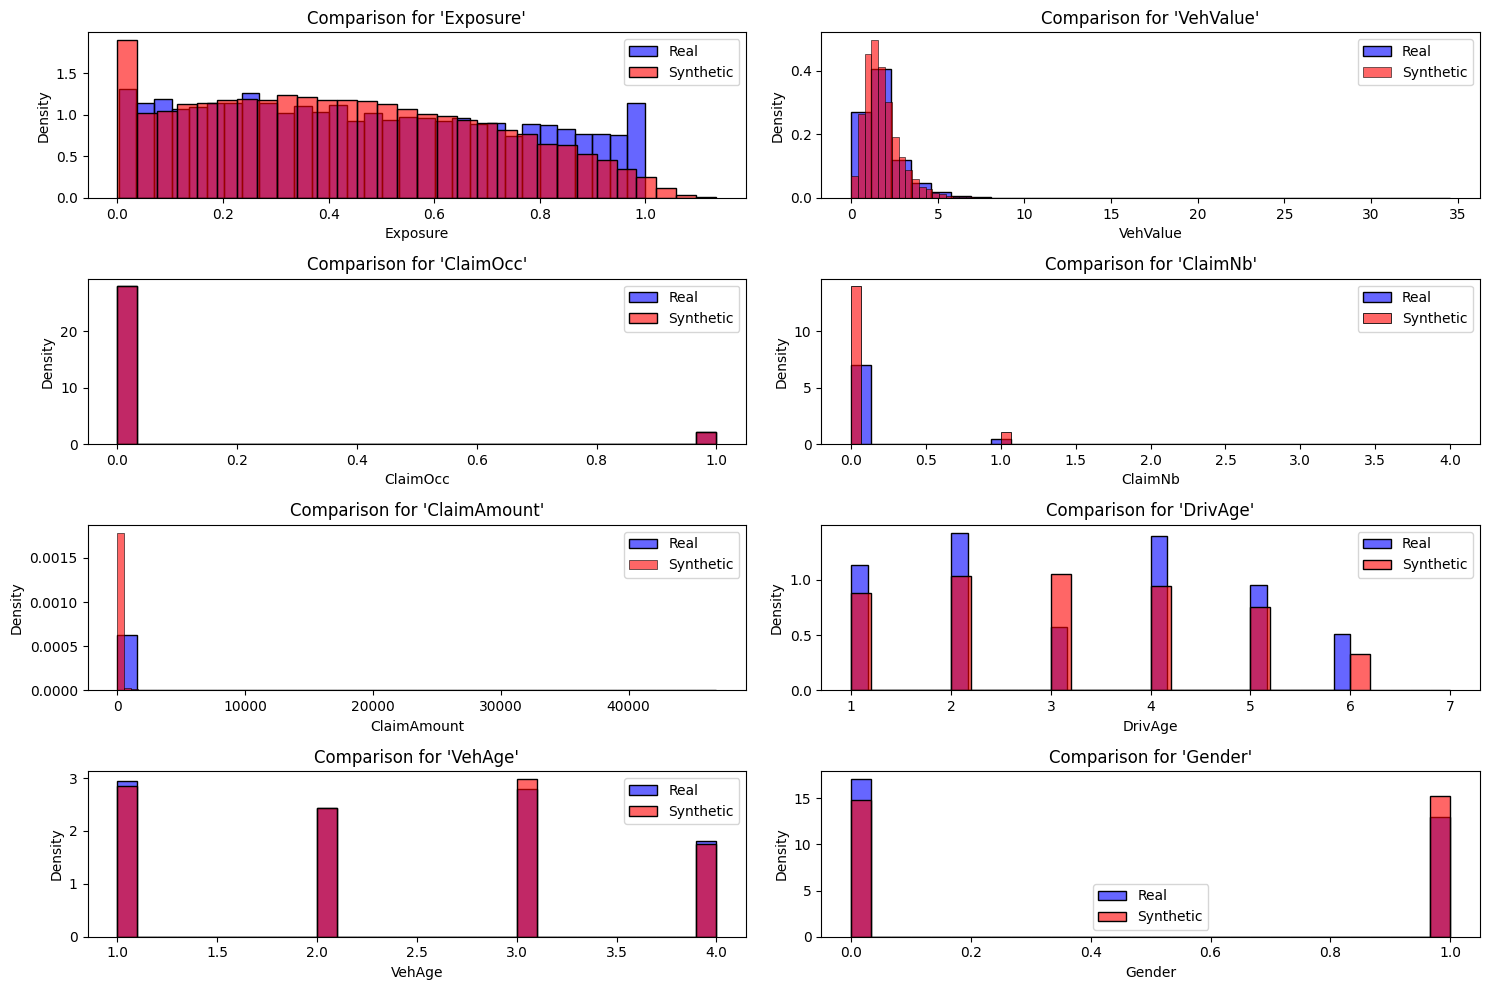

In [36]:
# Compare selected variables using histograms
compare_real_vs_synthetic(
    real_df=X_train,
    synthetic_df=synthetic_data,
    columns=['Exposure','VehValue','ClaimOcc','ClaimNb', 'ClaimAmount', 'DrivAge', 'VehAge','Gender'],
    kind='hist'
)


### Statistical Analysis

In [37]:
# Kolmogorov-Smirnov test
for column in X_train.columns:
    original = X_train[column].values
    generated = new_samples_df[column].values
    statistic, p_value = ks_2samp(original, generated)
    print(f"KS Test for {column}: Statistic={statistic}, P-value={p_value}")

KS Test for Exposure: Statistic=0.06652288072018009, P-value=5.092279239666236e-103
KS Test for VehValue: Statistic=0.03859714928732183, P-value=6.045376375188454e-35
KS Test for VehAge: Statistic=0.01181545386346583, P-value=0.0011608126764825627
KS Test for VehBody: Statistic=0.07620030007501877, P-value=4.442777109270947e-135
KS Test for Gender: Statistic=0.07644411102775694, P-value=6.0749825947747354e-136
KS Test for DrivAge: Statistic=0.07156789197299329, P-value=3.457302401234653e-119
KS Test for ClaimOcc: Statistic=0.0, P-value=1.0
KS Test for ClaimNb: Statistic=0.004163540885221306, P-value=0.7428557179549831
KS Test for ClaimAmount: Statistic=0.008945986496624148, P-value=0.027873035628807608


### PCA Analysis

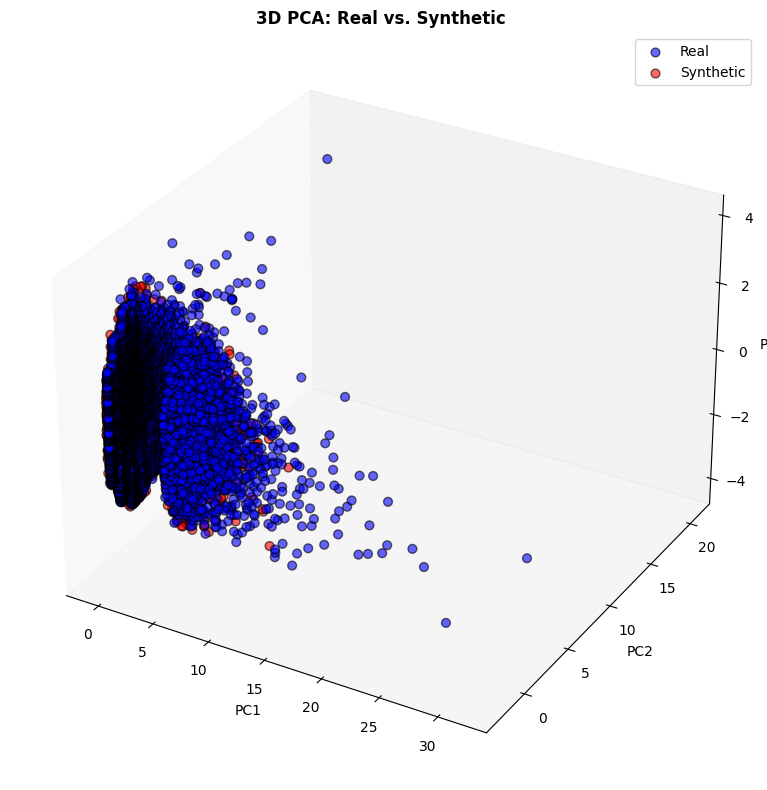

In [38]:
pca_visual_comparison_3d(X_train, synthetic_data)

In [39]:
#pca_visual_comparison(X_train, synthetic_data)


### UMAP Analysis

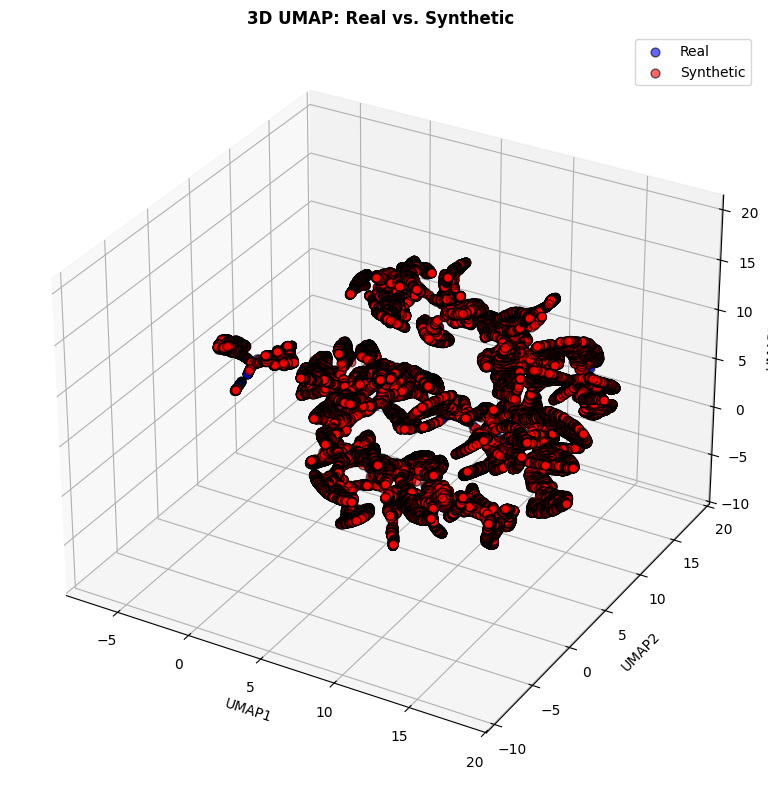

In [40]:
umap_visual_comparison_3d(X_train, synthetic_data)

In [41]:
#umap_visual_comparison(X_train, synthetic_data)


### GLM Frequency Analysis

In [42]:
# Baseline frequency model
results_frequency_1 = run_glm_frequency_analysis(X_train, X_test, label="Baseline")



Fold 1 Poisson Deviance Score: 1.6448
Fold 2 Poisson Deviance Score: 1.3600
Fold 3 Poisson Deviance Score: 1.0406
Fold 4 Poisson Deviance Score: 1.8229
Fold 5 Poisson Deviance Score: 1.3053
Average cross-validation Poisson Deviance Score: 1.4347
Standard Deviation of CV Scores: 0.2729
Train Poisson Deviance: 1.4345
Test Poisson Deviance: 1.7412


In [43]:
# Using synthetic sample data with exposure clipping
results_frequency_2 = run_glm_frequency_analysis(new_samples_df, X_test, clip_exposure=True, label="Synthetic Clipped")


Fold 1 Poisson Deviance Score: 2.3658
Fold 2 Poisson Deviance Score: 2.3727
Fold 3 Poisson Deviance Score: 3.5494
Fold 4 Poisson Deviance Score: 2.0533
Fold 5 Poisson Deviance Score: 3.2226
Average cross-validation Poisson Deviance Score: 2.7127
Standard Deviation of CV Scores: 0.5711
Train Poisson Deviance: 2.7117
Test Poisson Deviance: 1.7423


### GLM Cost Analysis

In [44]:
results_cost_1 = run_glm_cost_analysis(X_train, X_test)


Fold 1 Gamma Deviance Score: 1.5149
Fold 2 Gamma Deviance Score: 1.6084
Fold 3 Gamma Deviance Score: 1.4353
Fold 4 Gamma Deviance Score: 1.5815
Fold 5 Gamma Deviance Score: 1.6581
Average cross-validation Gamma Deviance Score: 1.5596604025666598
Standard Deviation of CV Scores: 0.07748353705257649
Train Gamma Deviance: 1.5509
Test Gamma Deviance: 1.7221


In [45]:
results_cost_2 = run_glm_cost_analysis(new_samples_df, X_test, is_sampled=True)


Fold 1 Gamma Deviance Score: 1.1104
Fold 2 Gamma Deviance Score: 1.0983
Fold 3 Gamma Deviance Score: 1.0852
Fold 4 Gamma Deviance Score: 1.0768
Fold 5 Gamma Deviance Score: 1.0775
Average cross-validation Gamma Deviance Score: 1.089640867837953
Standard Deviation of CV Scores: 0.012952002936363439
Train Gamma Deviance: 1.0874
Test Gamma Deviance: 2.1764


### Feature Importance Analysis


--- SHAP Feature Importance for Frequency Model ---


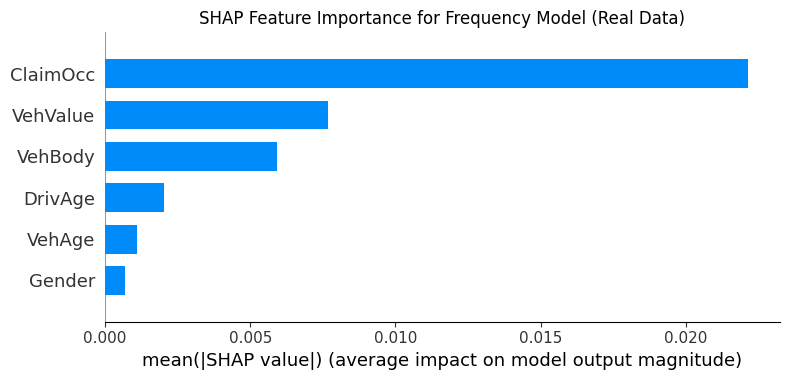


--- SHAP Feature Importance for Severity Model ---


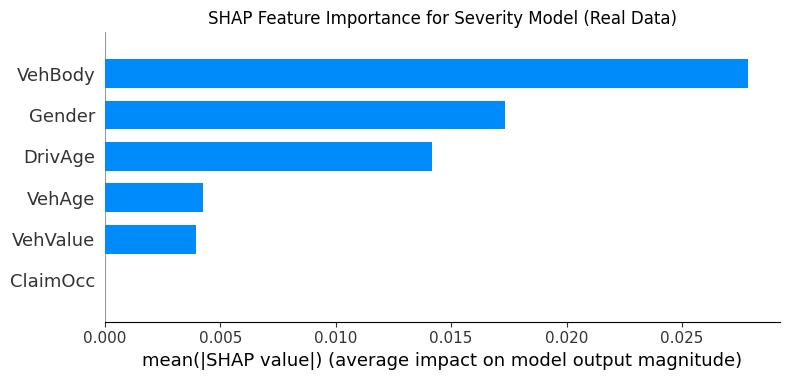

In [46]:
# --- SHAP Feature Importance for Frequency ---
print("\n--- SHAP Feature Importance for Frequency Model ---")

# Prepare data for frequency model SHAP
X_train_freq = X_train.drop(['Exposure', 'ClaimNb', 'ClaimAmount'], axis=1, errors='ignore')
y_train_freq = X_train['ClaimNb']
sample_weight_freq = X_train['Exposure']

X_test_freq = X_test.drop(['Exposure', 'ClaimNb', 'ClaimAmount'], axis=1, errors='ignore')

# Filter out rows with Exposure = 0 for frequency model training and SHAP explanation
# This step is crucial for consistency with how run_glm_frequency_analysis handles data
mask_train_freq = sample_weight_freq > 0
X_train_freq_filtered = X_train_freq[mask_train_freq]
y_train_freq_filtered = y_train_freq[mask_train_freq]
sample_weight_freq_filtered = sample_weight_freq[mask_train_freq]

# Ensure X_test_freq also only contains rows where Exposure > 0
# We need to apply the same mask to X_test to ensure `shap_values` is calculated on the same data.
# For SHAP, the `X_test` for explainer should correspond to the `X_test_` used in `run_glm_frequency_analysis`
mask_test_freq = X_test['Exposure'] > 0
X_test_freq_filtered = X_test_freq[mask_test_freq]


# Plot SHAP for Frequency
plot_glm_shap_importance(
    X_train=X_train_freq_filtered,
    X_test=X_test_freq_filtered,
    y_train=y_train_freq_filtered / sample_weight_freq_filtered, # Target is rate (ClaimNb / Exposure)
    sample_weight=sample_weight_freq_filtered,
    power=1, # Power=1 for Poisson (frequency)
    title="SHAP Feature Importance for Frequency Model (Real Data)",
    max_display=10
)

# --- SHAP Feature Importance for Severity ---
print("\n--- SHAP Feature Importance for Severity Model ---")

# Prepare data for severity model SHAP
X_train_cost_prep = X_train[X_train['ClaimAmount'] != 0].copy()
X_test_cost_prep = X_test[X_test['ClaimAmount'] != 0].copy()

X_train_sev = X_train_cost_prep.drop(columns=['Acost', 'Exposure', 'ClaimAmount', 'ClaimNb'], errors='ignore')
y_train_sev = X_train_cost_prep['ClaimAmount'] / X_train_cost_prep['ClaimNb']
sample_weight_sev = X_train_cost_prep['ClaimNb'] # Number of claims is the weight for severity

X_test_sev = X_test_cost_prep.drop(columns=['Acost', 'Exposure', 'ClaimAmount', 'ClaimNb'], errors='ignore')

# Plot SHAP for Severity
plot_glm_shap_importance(
    X_train=X_train_sev,
    X_test=X_test_sev,
    y_train=y_train_sev,
    sample_weight=sample_weight_sev,
    power=2, # Power=2 for Gamma (severity)
    title="SHAP Feature Importance for Severity Model (Real Data)",
    max_display=10
)


--- SHAP Feature Importance for Frequency Model (Synthetic Data) ---


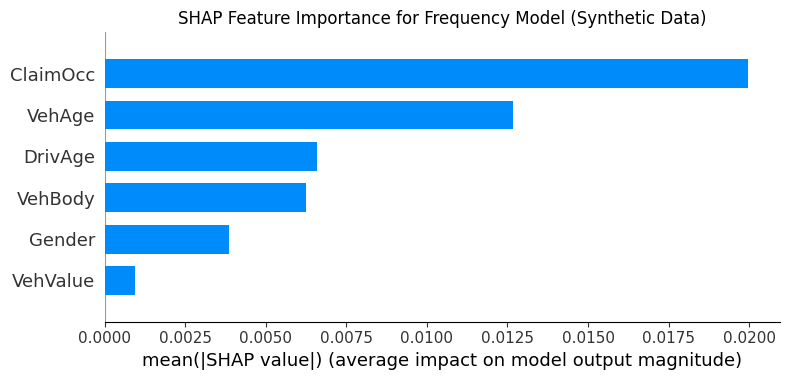


--- SHAP Feature Importance for Severity Model (Synthetic Data) ---


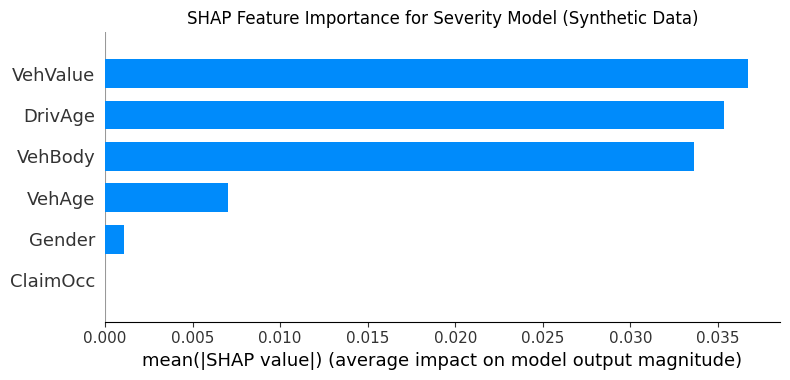

In [47]:
# --- SHAP Feature Importance for Frequency (Synthetic Data) ---
print("\n--- SHAP Feature Importance for Frequency Model (Synthetic Data) ---")

# Prepare data for frequency model SHAP using synthetic data
X_train_freq_synth = new_samples_df.drop(['Exposure', 'ClaimNb', 'ClaimAmount'], axis=1, errors='ignore')
y_train_freq_synth = new_samples_df['ClaimNb']
sample_weight_freq_synth = new_samples_df['Exposure']

# X_test_freq is the same as before (real test data)
X_test_freq = X_test.drop(['Exposure', 'ClaimNb', 'ClaimAmount'], axis=1, errors='ignore')

# Filter out rows with Exposure = 0 for frequency model training and SHAP explanation
mask_train_freq_synth = sample_weight_freq_synth > 0
X_train_freq_synth_filtered = X_train_freq_synth[mask_train_freq_synth]
y_train_freq_synth_filtered = y_train_freq_synth[mask_train_freq_synth]
sample_weight_freq_synth_filtered = sample_weight_freq_synth[mask_train_freq_synth]

# Ensure X_test_freq also only contains rows where Exposure > 0
mask_test_freq = X_test['Exposure'] > 0
X_test_freq_filtered = X_test_freq[mask_test_freq]

# Plot SHAP for Frequency (Synthetic Data)
plot_glm_shap_importance(
    X_train=X_train_freq_synth_filtered,
    X_test=X_test_freq_filtered,
    y_train=y_train_freq_synth_filtered / sample_weight_freq_synth_filtered, # Target is rate
    sample_weight=sample_weight_freq_synth_filtered,
    power=1, # Power=1 for Poisson (frequency)
    title="SHAP Feature Importance for Frequency Model (Synthetic Data)",
    max_display=10
)

# --- SHAP Feature Importance for Severity (Synthetic Data) ---
print("\n--- SHAP Feature Importance for Severity Model (Synthetic Data) ---")

# Prepare data for severity model SHAP using synthetic data
X_train_cost_prep_synth = new_samples_df[new_samples_df['ClaimAmount'] != 0].copy()
X_test_cost_prep_synth = X_test[X_test['ClaimAmount'] != 0].copy() # Keep using real test data for explanation

X_train_sev_synth = X_train_cost_prep_synth.drop(columns=['Acost', 'Exposure', 'ClaimAmount', 'ClaimNb'], errors='ignore')
y_train_sev_synth = X_train_cost_prep_synth['ClaimAmount'] / X_train_cost_prep_synth['ClaimNb']
sample_weight_sev_synth = X_train_cost_prep_synth['ClaimNb'] # Number of claims is the weight for severity

X_test_sev_synth = X_test_cost_prep_synth.drop(columns=['Acost', 'Exposure', 'ClaimAmount', 'ClaimNb'], errors='ignore')


# Plot SHAP for Severity (Synthetic Data)
plot_glm_shap_importance(
    X_train=X_train_sev_synth,
    X_test=X_test_sev_synth,
    y_train=y_train_sev_synth,
    sample_weight=sample_weight_sev_synth,
    power=2, # Power=2 for Gamma (severity)
    title="SHAP Feature Importance for Severity Model (Synthetic Data)",
    max_display=10
)

### Upload dataset and data handling

In [48]:
#---------------------
# D2
#---------------------
df2=pd.read_csv('/content/swmotorcycle.csv')

In [49]:
print(df2.shape)

(64548, 9)


In [50]:
print(df2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64548 entries, 0 to 64547
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   OwnerAge     64548 non-null  int64  
 1   Gender       64548 non-null  object 
 2   Area         64548 non-null  object 
 3   RiskClass    64548 non-null  object 
 4   VehAge       64548 non-null  int64  
 5   BonusClass   64548 non-null  object 
 6   Exposure     64548 non-null  float64
 7   ClaimNb      64548 non-null  int64  
 8   ClaimAmount  64548 non-null  int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 4.4+ MB
None


In [51]:
print(df2.columns)

Index(['OwnerAge', 'Gender', 'Area', 'RiskClass', 'VehAge', 'BonusClass',
       'Exposure', 'ClaimNb', 'ClaimAmount'],
      dtype='object')


In [52]:
df2.head()

,OwnerAge,Gender,Area,RiskClass,VehAge,BonusClass,Exposure,ClaimNb,ClaimAmount
0,0,Male,Central parts of Sweden's three largest cities,EV ratio 13-15,12,BM1,0.175342,0,0
1,4,Male,Lesser towns except Gotland; Northern towns,EV ratio 20-24,9,BM1,0.000000,0,0
2,5,Female,Lesser towns except Gotland; Northern towns,EV ratio 9-12,18,BM1,0.454795,0,0
3,5,Female,Small towns; countryside except Gotland; North...,EV ratio <5,25,BM1,0.172603,0,0
4,6,Female,Suburbs; middle-sized cities,EV ratio <5,26,BM1,0.180822,0,0


In [53]:
df2_duplicated_rows=df2[df2.duplicated()]
df2_duplicated_rows

,OwnerAge,Gender,Area,RiskClass,VehAge,BonusClass,Exposure,ClaimNb,ClaimAmount


In [54]:
df2=df2.drop_duplicates()

In [55]:
df2_duplicated_col=df2.columns[df2.columns.duplicated()]
df2_duplicated_col

Index([], dtype='object')

In [56]:
missing=df2.isnull().sum()/df2.shape[0]*100
missing

,0
OwnerAge,0.0
Gender,0.0
Area,0.0
RiskClass,0.0
VehAge,0.0
BonusClass,0.0
Exposure,0.0
ClaimNb,0.0
ClaimAmount,0.0


In [57]:
# add ClaimOcc feature
df_2 = df2.copy()
df_2['ClaimOcc'] = np.where(df_2['ClaimNb'] > 0, 1, 0)
# Feature transformation
df_2['Exposure'] = df_2['Exposure'].clip(upper=1)
df_2['VehAge'] = df_2['VehAge'].clip(upper=20)

### Encoding

In [58]:
print(df_2['Gender'].unique())
print(df_2['Area'].unique())
print(df_2['RiskClass'].unique())
print(df_2['BonusClass'].unique())


['Male' 'Female']
["Central parts of Sweden's three largest cities"
 'Lesser towns except Gotland; Northern towns'
 'Small towns; countryside except Gotland; Northern towns'
 'Suburbs; middle-sized cities' 'Northern countryside' 'Northern towns'
 "Gotland (Sweden's largest island)"]
['EV ratio 13-15' 'EV ratio 20-24' 'EV ratio 9-12' 'EV ratio <5'
 'EV ratio 6-8' 'EV ratio 16-19' 'EV ratio >25']
['BM1' 'BM2' 'BM3' 'BM4' 'BM7' 'BM5' 'BM6']


In [59]:
df2_encod=df_2.copy()
# RiskClass
RiskClass_group = {'EV ratio 13-15':'1','EV ratio 20-24':'2','EV ratio 9-12':'3','EV ratio <5':'4','EV ratio 6-8':'5',\
                   'EV ratio 16-19':'6','EV ratio >25':'7'}
df2_encod['RiskClass'] = df2_encod['RiskClass'].map(RiskClass_group)
df2_encod['RiskClass']= df2_encod['RiskClass'].astype(int)
# BonusClass
BonusClass_group = {'BM1':'1','BM2':'2','BM3':'3','BM4':'4','BM5':'5','BM6':'6','BM7':'7'}
df2_encod['BonusClass'] = df2_encod['BonusClass'].map(BonusClass_group)
df2_encod['BonusClass']= df2_encod['BonusClass'].astype(int)
# Area
Area_group = {"Central parts of Sweden's three largest cities":'1','Lesser towns except Gotland; Northern towns':'2',\
              'Small towns; countryside except Gotland; Northern towns':'3','Suburbs; middle-sized cities':'4',\
              'Northern countryside':'5','Northern towns':'6',"Gotland (Sweden's largest island)":'7'}
df2_encod['Area'] = df2_encod['Area'].map(Area_group)
df2_encod['Area']= df2_encod['Area'].astype(int)
# Gender
Gender_group = {'Female':'0','Male':'1'}
df2_encod['Gender'] = df2_encod['Gender'].map(Gender_group)
df2_encod['Gender']= df2_encod['Gender'].astype(int)




In [60]:
df2_encod.head()

,OwnerAge,Gender,Area,RiskClass,VehAge,BonusClass,Exposure,ClaimNb,ClaimAmount,ClaimOcc
0,0,1,1,1,12,1,0.175342,0,0,0
1,4,1,2,2,9,1,0.000000,0,0,0
2,5,0,2,3,18,1,0.454795,0,0,0
3,5,0,3,4,20,1,0.172603,0,0,0
4,6,0,4,4,20,1,0.180822,0,0,0


### Split dataset

In [61]:
# Split the dataset into train/test split
X_train, X_test = train_test_split(df2_encod, test_size=0.2, random_state=0)

In [62]:
X_train.shape

(51638, 10)

### Build a CDF

In [63]:
## Data Preparation
# Set random seeds for reproducibility
np.random.seed(0)
tf.random.set_seed(0)

# Define columns
condition_col = 'ClaimOcc'          # Binary condition
target_discrete = 'ClaimNb'         # Discrete variable
target_continuous = 'ClaimAmount'   # Continuous variable

# Define features to include 'ClaimNb' and 'ClaimAmount' and exclude 'ClaimOcc'
features = [col for col in X_train.columns if col != condition_col]

# Extract features and condition, ensuring float32 data type
X_features = X_train[features].values.astype(np.float32)        # Ensure float32
X_condition = X_train[condition_col].values.reshape(-1, 1).astype(np.float32)  # Ensure float32

# Normalize all features using standard normalization
means = np.mean(X_features, axis=0).astype(np.float32)
stds = np.std(X_features, axis=0).astype(np.float32)
# To avoid division by zero
stds_corrected = np.where(stds == 0, 1, stds).astype(np.float32)
X_features_normalized = (X_features - means) / stds_corrected
X_features_normalized = X_features_normalized.astype(np.float32)  # Ensure float32

# Prepare the input for the diffusion model (features + condition)
X_input = np.concatenate([X_features_normalized, X_condition], axis=1).astype(np.float32)  # Ensure float32

# Define dimensions
input_dim = X_input.shape[1]        # Number of features + condition
condition_dim = 1                   # Since ClaimOcc is binary

print(f"Shape of X_input: {X_input.shape}")

## Define diffusion process
class DiffusionModel:
    def __init__(self, input_dim, timesteps=1000, beta_start=1e-4, beta_end=0.02):
        self.input_dim = input_dim
        self.timesteps = timesteps

        # Linear beta schedule with float32
        self.beta = np.linspace(beta_start, beta_end, timesteps, dtype=np.float32)
        self.alpha = 1.0 - self.beta
        self.alpha_cumprod = np.cumprod(self.alpha).astype(np.float32)
        self.alpha_cumprod_prev = np.concatenate(
            (np.array([1.0], dtype=np.float32), self.alpha_cumprod[:-1])
        ).astype(np.float32)

    def q_sample(self, x_start, t, noise=None):
        if noise is None:
            noise = tf.random.normal(shape=x_start.shape, dtype=tf.float32)  # Ensure float32
        # Convert alpha_cumprod to float32 tensors
        alpha_cumprod = tf.constant(self.alpha_cumprod, dtype=tf.float32)
        one = tf.constant(1.0, dtype=tf.float32)

        sqrt_alpha_cumprod = tf.gather(alpha_cumprod, t)[:, None]
        sqrt_one_minus_alpha_cumprod = tf.gather(one - alpha_cumprod, t)[:, None]
        return sqrt_alpha_cumprod * x_start + sqrt_one_minus_alpha_cumprod * noise

def build_unet(input_dim, condition_dim, timesteps=1000):
    """
    Builds a U-Net-like architecture for tabular data.

    Parameters:
    - input_dim: Dimension of the input features including condition
    - condition_dim: Dimension of the condition variable
    - timesteps: Number of diffusion timesteps

    Returns:
    - A Keras Model representing the U-Net denoising network
    """
    # Inputs
    x_input = layers.Input(shape=(input_dim,), dtype='float32', name='input_features')
    t_input = layers.Input(shape=(), dtype=tf.int32, name='timesteps')  # Timestep
    condition_input = layers.Input(shape=(condition_dim,), dtype='float32', name='condition')

    # Timestep Embedding
    t_embed = layers.Embedding(input_dim=timesteps, output_dim=64, dtype='float32')(t_input)
    t_embed = layers.Dense(64, activation='relu')(t_embed)
    t_embed = layers.Dense(64, activation='relu')(t_embed)

    # Concatenate all inputs
    x = layers.Concatenate()([x_input, condition_input, t_embed])

    # Encoder
    encoder_layer1 = layers.Dense(512, activation='relu')(x)
    encoder_layer2 = layers.Dense(512, activation='relu')(encoder_layer1)
    encoder_layer3 = layers.Dense(512, activation='relu')(encoder_layer2)

    # Bottleneck
    bottleneck = layers.Dense(512, activation='relu')(encoder_layer3)

    # Decoder
    decoder_layer1 = layers.Dense(512, activation='relu')(bottleneck)
    decoder_layer1 = layers.Concatenate()([decoder_layer1, encoder_layer3])  # Skip connection

    decoder_layer2 = layers.Dense(512, activation='relu')(decoder_layer1)
    decoder_layer2 = layers.Concatenate()([decoder_layer2, encoder_layer2])  # Skip connection

    decoder_layer3 = layers.Dense(512, activation='relu')(decoder_layer2)
    decoder_layer3 = layers.Concatenate()([decoder_layer3, encoder_layer1])  # Skip connection

    # Output
    output = layers.Dense(input_dim, activation='linear')(decoder_layer3)

    # Define the model
    model = Model(inputs=[x_input, t_input, condition_input], outputs=output, name='UNet_DiffusionModel')
    return model

# Start the U-Net denoising model
unet_model = build_unet(input_dim=input_dim, condition_dim=condition_dim, timesteps=1000)
unet_model.summary()

# Start the diffusion process
diffusion = DiffusionModel(input_dim=input_dim, timesteps=1000)

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Training parameters
batch_size = 128
epochs = 30
steps_per_epoch = X_input.shape[0] // batch_size

# Prepare TensorFlow dataset
dataset = tf.data.Dataset.from_tensor_slices((X_input, X_input[:, -condition_dim:]))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)

@tf.function
def train_step(x, condition):
    # Sample random timestep for each example in the batch
    t = tf.random.uniform(shape=(tf.shape(x)[0],), minval=0, maxval=1000, dtype=tf.int32)

    # Sample noise
    noise = tf.random.normal(shape=x.shape, dtype=tf.float32)  # Ensure float32

    # Get noised data
    x_noised = diffusion.q_sample(x, t, noise)

    with tf.GradientTape() as tape:
        # Predict the noise
        noise_pred = unet_model([x_noised, t, condition], training=True)
        # Compute loss
        loss = tf.reduce_mean(tf.square(noise - noise_pred))

    # Backpropagation
    gradients = tape.gradient(loss, unet_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, unet_model.trainable_variables))

    return loss

# Training loop
for epoch in range(epochs):
    epoch_loss = 0.0
    for step, (x_batch, condition_batch) in enumerate(tqdm(dataset, desc=f"Epoch {epoch + 1}/{epochs}")):
        loss = train_step(x_batch, condition_batch)
        epoch_loss += loss.numpy()
    epoch_loss /= steps_per_epoch
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}")

def sample_diffusion(model, diffusion, condition, num_samples):
    """
    Generates samples by reversing the diffusion process.

    Parameters:
    - model: The trained denoising model
    - diffusion: The diffusion process instance
    - condition: Condition tensor
    - num_samples: Number of samples to generate

    Returns:
    - Tensor containing generated samples
    """
    x = tf.random.normal(shape=(num_samples, diffusion.input_dim), dtype=tf.float32)  # Ensure float32
    for t in tqdm(range(diffusion.timesteps - 1, -1, -1), desc="Sampling"):
        t_tensor = tf.fill([num_samples], t)
        noise_pred = model([x, t_tensor, condition], training=False)

        beta_t = diffusion.beta[t]
        alpha_t = diffusion.alpha[t]
        alpha_cumprod_t = diffusion.alpha_cumprod[t]
        alpha_cumprod_prev_t = diffusion.alpha_cumprod_prev[t]

        # Convert to float32 tensors
        beta_t = tf.constant(beta_t, dtype=tf.float32)
        alpha_t = tf.constant(alpha_t, dtype=tf.float32)
        alpha_cumprod_t = tf.constant(alpha_cumprod_t, dtype=tf.float32)

        one = tf.constant(1.0, dtype=tf.float32)

        sqrt_alpha_t = tf.sqrt(alpha_t)
        inv_sqrt_alpha_t = one / sqrt_alpha_t

        one_minus_alpha_t = one - alpha_t
        sqrt_one_minus_alpha_cumprod_t = tf.sqrt(one - alpha_cumprod_t)
        inv_sqrt_one_minus_alpha_cumprod_t = one / sqrt_one_minus_alpha_cumprod_t

        # Compute x
        x = inv_sqrt_alpha_t * (x - (one_minus_alpha_t * inv_sqrt_one_minus_alpha_cumprod_t) * noise_pred)

        if t > 0:
            noise = tf.random.normal(shape=(num_samples, diffusion.input_dim), dtype=tf.float32)  # Ensure float32
            x = x + tf.sqrt(beta_t) * noise
    return x





Shape of X_input: (51638, 10)


Model: "UNet_DiffusionModel"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ timesteps           │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 64)        │     64,000 │ timesteps[0][0]   │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 64)        │      4,160 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_features      │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ condition           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 64)        │      4,160 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 75)        │          0 │ input_features[0… │
│ (Concatenate)       │                   │            │ condition[0][0],  │
│                     │                   │            │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 512)       │     38,912 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 512)       │    262,656 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 512)       │    262,656 │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 512)       │    262,656 │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 512)       │    262,656 │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 1024)      │          0 │ dense_16[0][0],   │
│ (Concatenate)       │                   │            │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 512)       │    524,800 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 1024)      │          0 │ dense_17[0][0],   │
│ (Concatenate)       │                   │            │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 512)       │    524,800 │ concatenate_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 1024)      │          0 │ dense_18[0][0],   │
│ (Concatenate)       │                   │            │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 10)        │     10,250 │ concatenate_7[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,221,706 (8.48 MB)

 Trainable params: 2,221,706 (8.48 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30: 100%|██████████| 404/404 [00:05<00:00, 76.67it/s] 


Epoch 1/30, Loss: 0.2704


Epoch 2/30: 100%|██████████| 404/404 [00:02<00:00, 191.83it/s]


Epoch 2/30, Loss: 0.2007


Epoch 3/30: 100%|██████████| 404/404 [00:02<00:00, 186.51it/s]


Epoch 3/30, Loss: 0.1913


Epoch 4/30: 100%|██████████| 404/404 [00:02<00:00, 191.56it/s]


Epoch 4/30, Loss: 0.1865


Epoch 5/30: 100%|██████████| 404/404 [00:02<00:00, 190.63it/s]


Epoch 5/30, Loss: 0.1779


Epoch 6/30: 100%|██████████| 404/404 [00:02<00:00, 192.04it/s]


Epoch 6/30, Loss: 0.1765


Epoch 7/30: 100%|██████████| 404/404 [00:02<00:00, 192.45it/s]


Epoch 7/30, Loss: 0.1747


Epoch 8/30: 100%|██████████| 404/404 [00:02<00:00, 187.71it/s]


Epoch 8/30, Loss: 0.1718


Epoch 9/30: 100%|██████████| 404/404 [00:02<00:00, 188.61it/s]


Epoch 9/30, Loss: 0.1692


Epoch 10/30: 100%|██████████| 404/404 [00:02<00:00, 190.10it/s]


Epoch 10/30, Loss: 0.1703


Epoch 11/30: 100%|██████████| 404/404 [00:02<00:00, 190.76it/s]


Epoch 11/30, Loss: 0.1696


Epoch 12/30: 100%|██████████| 404/404 [00:02<00:00, 190.43it/s]


Epoch 12/30, Loss: 0.1679


Epoch 13/30: 100%|██████████| 404/404 [00:02<00:00, 189.97it/s]


Epoch 13/30, Loss: 0.1684


Epoch 14/30: 100%|██████████| 404/404 [00:02<00:00, 186.26it/s]


Epoch 14/30, Loss: 0.1640


Epoch 15/30: 100%|██████████| 404/404 [00:02<00:00, 191.43it/s]


Epoch 15/30, Loss: 0.1695


Epoch 16/30: 100%|██████████| 404/404 [00:02<00:00, 191.37it/s]


Epoch 16/30, Loss: 0.1662


Epoch 17/30: 100%|██████████| 404/404 [00:02<00:00, 190.74it/s]


Epoch 17/30, Loss: 0.1652


Epoch 18/30: 100%|██████████| 404/404 [00:02<00:00, 192.04it/s]


Epoch 18/30, Loss: 0.1630


Epoch 19/30: 100%|██████████| 404/404 [00:02<00:00, 182.36it/s]


Epoch 19/30, Loss: 0.1622


Epoch 20/30: 100%|██████████| 404/404 [00:02<00:00, 190.91it/s]


Epoch 20/30, Loss: 0.1637


Epoch 21/30: 100%|██████████| 404/404 [00:02<00:00, 191.26it/s]


Epoch 21/30, Loss: 0.1617


Epoch 22/30: 100%|██████████| 404/404 [00:02<00:00, 189.93it/s]


Epoch 22/30, Loss: 0.1630


Epoch 23/30: 100%|██████████| 404/404 [00:02<00:00, 190.68it/s]


Epoch 23/30, Loss: 0.1614


Epoch 24/30: 100%|██████████| 404/404 [00:02<00:00, 188.30it/s]


Epoch 24/30, Loss: 0.1593


Epoch 25/30: 100%|██████████| 404/404 [00:02<00:00, 187.30it/s]


Epoch 25/30, Loss: 0.1587


Epoch 26/30: 100%|██████████| 404/404 [00:02<00:00, 191.28it/s]


Epoch 26/30, Loss: 0.1596


Epoch 27/30: 100%|██████████| 404/404 [00:02<00:00, 190.65it/s]


Epoch 27/30, Loss: 0.1604


Epoch 28/30: 100%|██████████| 404/404 [00:02<00:00, 189.33it/s]


Epoch 28/30, Loss: 0.1583


Epoch 29/30: 100%|██████████| 404/404 [00:02<00:00, 189.93it/s]


Epoch 29/30, Loss: 0.1578


Epoch 30/30: 100%|██████████| 404/404 [00:02<00:00, 186.62it/s]

Epoch 30/30, Loss: 0.1580


### Generate Samples

In [64]:
def generate_synthetic_data(model, diffusion, num_samples, claim_occ_value=0,
                            columns_to_round=None, exposure_mean=None,
                            min_claim_amount=None):
    """
    Generates synthetic data with specified ClaimOcc value, incorporating CVAE constraints.

    Parameters:
    - model: The trained denoising model (UNet)
    - diffusion: The diffusion process instance
    - num_samples: Number of samples to generate
    - claim_occ_value: Value of ClaimOcc to condition on (0 or 1)
    - columns_to_round: List of column names to round to nearest integer
    - exposure_mean: Mean value of 'Exposure' to replace zeros
    - min_claim_amount: Minimum value to enforce for 'ClaimAmount' when 'ClaimNb' > 0

    Returns:
    - DataFrame containing generated synthetic data
    """
    # Define conditions
    condition = np.full((num_samples, condition_dim), claim_occ_value).astype(np.float32)

    # Convert to tensor
    condition_tensor = tf.convert_to_tensor(condition, dtype=tf.float32)

    # Generate samples
    generated_noised = sample_diffusion(model, diffusion, condition_tensor, num_samples)

    # Convert to numpy array
    generated_noised = generated_noised.numpy()

    # Separate features and condition_col
    generated_features_noised = generated_noised[:, :-1]  # Assuming last column is condition_col

    # Rescale features to original scale
    generated_features = generated_features_noised * stds_corrected + means

    # Convert to DataFrame
    generated_data = pd.DataFrame(generated_features, columns=features)

    # Assign the condition variable
    generated_data[condition_col] = claim_occ_value

    # Handle discrete variables: 'ClaimNb'
    if target_discrete in features:
        claim_nb_idx = features.index(target_discrete)
        # Round 'ClaimNb' to the nearest integer
        generated_data[target_discrete] = np.round(generated_data[target_discrete]).astype(int)
    else:
        raise ValueError(f"Target discrete column '{target_discrete}' not found in features.")

    # Handle 'ClaimAmount' based on 'ClaimNb'
    if target_continuous in features:
        claim_amount_idx = features.index(target_continuous)
        generated_claim_nb = generated_data[target_discrete].values
        # Set 'ClaimAmount' to 0 where 'ClaimNb' is 0
        generated_data[target_continuous] = np.where(generated_claim_nb == 0, 0, generated_data[target_continuous])

        if min_claim_amount is not None:
            # Enforce minimum 'ClaimAmount' where 'ClaimNb' > 0
            generated_data[target_continuous] = np.where(
                generated_claim_nb > 0,
                generated_data[target_continuous].clip(lower=min_claim_amount),
                generated_data[target_continuous]
            )
    else:
        raise ValueError(f"Target continuous column '{target_continuous}' not found in features.")

    # Post-processing: Round Specific Columns and Clip Negative Values
    if columns_to_round is not None:
        # Check if these columns exist in the generated data
        missing_round_columns = [col for col in columns_to_round if col not in generated_data.columns]
        if missing_round_columns:
            raise ValueError(f"The following columns to round are missing in generated data: {missing_round_columns}")

        # Round the specified columns to nearest integer
        generated_data[columns_to_round] = generated_data[columns_to_round].round().astype(int)

    # Replace negative values with zero for all numerical columns
    numerical_cols = generated_data.select_dtypes(include=[np.number]).columns.tolist()
    generated_data[numerical_cols] = generated_data[numerical_cols].clip(lower=0)

    return generated_data

# Define CVAE-like constraints
columns_to_round = ['Gender','Area','RiskClass','BonusClass']
min_claim_amount = X_train['ClaimAmount'].mean()  # Or another suitable value based on your data

# Define generation parameters
num_samples = X_train.shape[0]
num_samples_claim0 = X_train[X_train['ClaimOcc']==0].shape[0]
num_samples_claim1 = num_samples - num_samples_claim0

# Generate samples with ClaimOcc=0
synthetic_data_claim0 = generate_synthetic_data(
    model=unet_model,
    diffusion=diffusion,
    num_samples=num_samples_claim0,
    claim_occ_value=0,
    columns_to_round=columns_to_round,
    min_claim_amount=min_claim_amount
)

# Generate samples with ClaimOcc=1
synthetic_data_claim1 = generate_synthetic_data(
    model=unet_model,
    diffusion=diffusion,
    num_samples=num_samples_claim1,
    claim_occ_value=1,
    columns_to_round=columns_to_round,
    min_claim_amount=min_claim_amount
)

# Combine the datasets
synthetic_data = pd.concat([synthetic_data_claim0, synthetic_data_claim1], ignore_index=True)

# Shuffle the dataset to mix ClaimOcc=0 and ClaimOcc=1 samples
synthetic_data = synthetic_data.sample(frac=1, random_state=0).reset_index(drop=True)



Sampling: 100%|██████████| 1000/1000 [00:18<00:00, 52.82it/s]


### Use Generate Samples Dataframe

In [65]:
new_samples_df=synthetic_data.copy()

### Data Comparison

In [66]:
X_train.head()

,OwnerAge,Gender,Area,RiskClass,VehAge,BonusClass,Exposure,ClaimNb,ClaimAmount,ClaimOcc
17537,32,1,4,2,10,4,0.668493,0,0,0
36594,46,1,4,6,16,3,1.000000,0,0,0
49674,53,0,1,6,14,2,0.495890,0,0,0
60665,62,1,2,3,14,3,0.498630,0,0,0
28321,42,1,4,3,15,2,0.961644,0,0,0


In [67]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
OwnerAge,51638.0,42.381250,12.979286,0.0,31.000000,44.000000,52.0,92.0
Gender,51638.0,0.848581,0.358461,0.0,1.000000,1.000000,1.0,1.0
Area,51638.0,2.973643,1.253283,1.0,2.000000,3.000000,4.0,7.0
RiskClass,51638.0,3.356714,1.747525,1.0,2.000000,3.000000,5.0,7.0
VehAge,51638.0,11.114722,6.365856,0.0,5.000000,12.000000,16.0,20.0
BonusClass,51638.0,4.020508,2.364091,1.0,2.000000,4.000000,7.0,7.0
Exposure,51638.0,0.687829,0.332135,0.0,0.463014,0.821918,1.0,1.0
ClaimNb,51638.0,0.010535,0.105824,0.0,0.000000,0.000000,0.0,2.0
ClaimAmount,51638.0,260.434583,4748.164398,0.0,0.000000,0.000000,0.0,365347.0
ClaimOcc,51638.0,0.010148,0.100224,0.0,0.000000,0.000000,0.0,1.0


In [68]:
new_samples_df.head()

,OwnerAge,Gender,Area,RiskClass,VehAge,BonusClass,Exposure,ClaimNb,ClaimAmount,ClaimOcc
0,41.729946,1,2,1,9.666685,7,0.492764,0,0.0,0
1,46.171726,1,4,5,8.882071,7,0.984830,0,0.0,0
2,52.235489,1,3,4,1.634490,1,0.817164,0,0.0,0
3,31.770508,1,3,1,15.805498,3,0.854457,0,0.0,0
4,32.863834,0,5,2,12.397501,7,0.976458,0,0.0,0


In [69]:
new_samples_df.describe().T

,count,mean,std,min,25%,50%,75%,max
OwnerAge,51638.0,42.501965,12.954476,7.283165,32.649303,42.241821,51.941719,87.445084
Gender,51638.0,0.866629,0.339978,0.000000,1.000000,1.000000,1.000000,1.000000
Area,51638.0,2.983191,1.305818,0.000000,2.000000,3.000000,4.000000,8.000000
RiskClass,51638.0,3.395968,1.694841,1.000000,2.000000,3.000000,5.000000,11.000000
VehAge,51638.0,11.241302,5.690141,0.000000,6.615687,11.487556,16.151432,22.384792
BonusClass,51638.0,3.806151,2.138184,0.000000,2.000000,4.000000,6.000000,8.000000
Exposure,51638.0,0.633931,0.304519,0.000000,0.390098,0.680509,0.925625,1.052136
ClaimNb,51638.0,0.009373,0.096360,0.000000,0.000000,0.000000,0.000000,1.000000
ClaimAmount,51638.0,59.899000,914.326494,0.000000,0.000000,0.000000,0.000000,53191.406250
ClaimOcc,51638.0,0.010148,0.100224,0.000000,0.000000,0.000000,0.000000,1.000000


In [70]:
# Check for consistency
consistent_zeros = ((X_train["ClaimNb"] == 0) & (X_train["ClaimOcc"] == 0) & (X_train["ClaimAmount"] == 0)).sum()
consistent_positives = ((X_train["ClaimNb"] > 0) & (X_train["ClaimOcc"] > 0) & (X_train["ClaimAmount"] > 0)).sum()

# Display results
print(f"Records where all three are zero: {consistent_zeros}")
print(f"Records where all three are positive: {consistent_positives}")

Records where all three are zero: 51114
Records where all three are positive: 524


In [71]:
# Check for consistency
consistent_zeros = ((new_samples_df["ClaimNb"] == 0) & (new_samples_df["ClaimOcc"] == 0) & (new_samples_df["ClaimAmount"] == 0)).sum()
consistent_positives = ((new_samples_df["ClaimNb"] > 0) & (new_samples_df["ClaimOcc"] > 0) & (new_samples_df["ClaimAmount"] > 0)).sum()

# Display results
print(f"Records where all three are zero: {consistent_zeros}")
print(f"Records where all three are positive: {consistent_positives}")

Records where all three are zero: 51114
Records where all three are positive: 484


In [72]:
# Find inconsistencies
inconsistent_records = new_samples_df[
    ~(((new_samples_df["ClaimNb"] == 0) & (new_samples_df["ClaimOcc"] == 0) & (new_samples_df["ClaimAmount"] == 0)) |
      ((new_samples_df["ClaimNb"] > 0) & (new_samples_df["ClaimOcc"] > 0) & (new_samples_df["ClaimAmount"] > 0)))
]

print(f"Number of inconsistent records: {len(inconsistent_records)}")
print(inconsistent_records.head())  # Show a few inconsistent rows

Number of inconsistent records: 40
       OwnerAge  Gender  Area  RiskClass     VehAge  BonusClass  Exposure  \
2431  33.425461       0     2          3   8.490179           2  0.961612   
2592  38.062271       1     3          4   6.380205           1  0.472607   
3758  36.979771       1     1          6   9.446502           5  0.223580   
3917  17.993034       1     5          4   0.816963           7  0.618522   
4261  57.678410       1     7          3  14.946422           6  0.330103   

      ClaimNb  ClaimAmount  ClaimOcc  
2431        0          0.0         1  
2592        0          0.0         1  
3758        0          0.0         1  
3917        0          0.0         1  
4261        0          0.0         1  


### Visual Comparison

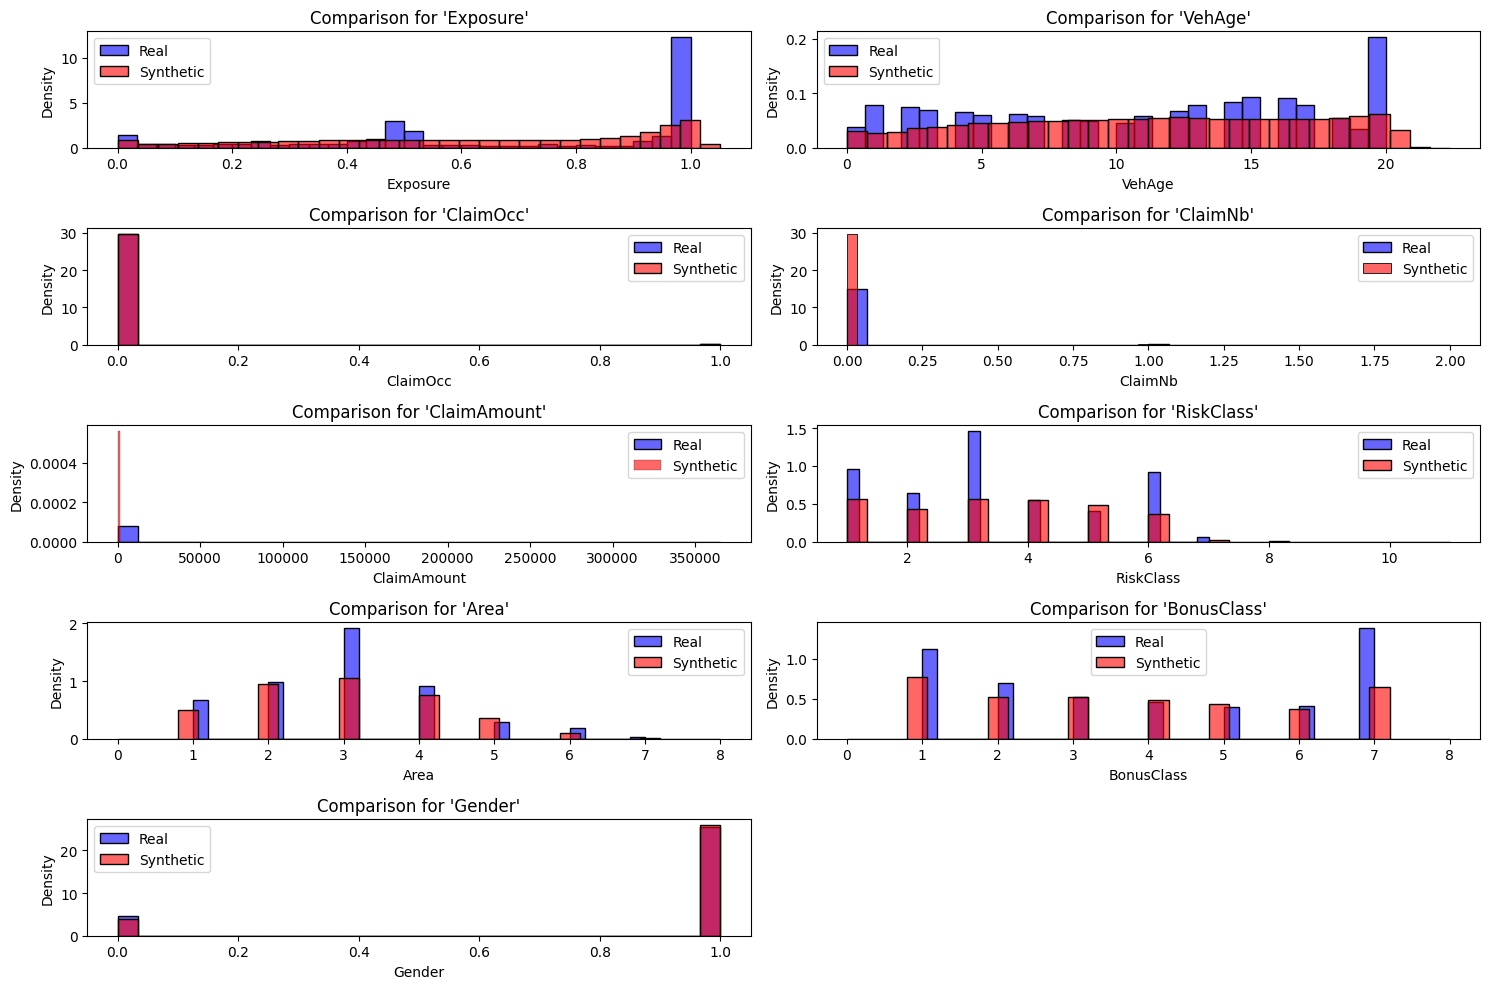

In [73]:
# Compare selected variables using histograms
compare_real_vs_synthetic(
    real_df=X_train,
    synthetic_df=synthetic_data,
    columns=['Exposure','VehAge','ClaimOcc','ClaimNb', 'ClaimAmount', 'RiskClass', 'Area','BonusClass','Gender'],
    kind='hist'
)


### Statistical Analysis

In [74]:
# Kolmogorov-Smirnov test
for column in X_train.columns:
    original = X_train[column].values
    generated = new_samples_df[column].values
    statistic, p_value = ks_2samp(original, generated)
    print(f"KS Test for {column}: Statistic={statistic}, P-value={p_value}")

KS Test for OwnerAge: Statistic=0.06386769433363026, P-value=5.2759199396377644e-92
KS Test for Gender: Statistic=0.01804872380804834, P-value=9.769942018813477e-08
KS Test for Area: Statistic=0.055559859018552205, P-value=1.0253714477484506e-69
KS Test for RiskClass: Statistic=0.0912312637979783, P-value=1.878222809594969e-187
KS Test for VehAge: Statistic=0.10288934505596647, P-value=2.0135735112002124e-238
KS Test for BonusClass: Statistic=0.1032766567256671, P-value=3.1959862915198214e-240
KS Test for Exposure: Statistic=0.3056857353112049, P-value=0.0
KS Test for ClaimNb: Statistic=0.0007746233394012592, P-value=1.0
KS Test for ClaimAmount: Statistic=0.0031759556915450515, P-value=0.9562147997377185
KS Test for ClaimOcc: Statistic=0.0, P-value=1.0


### PCA Analysis

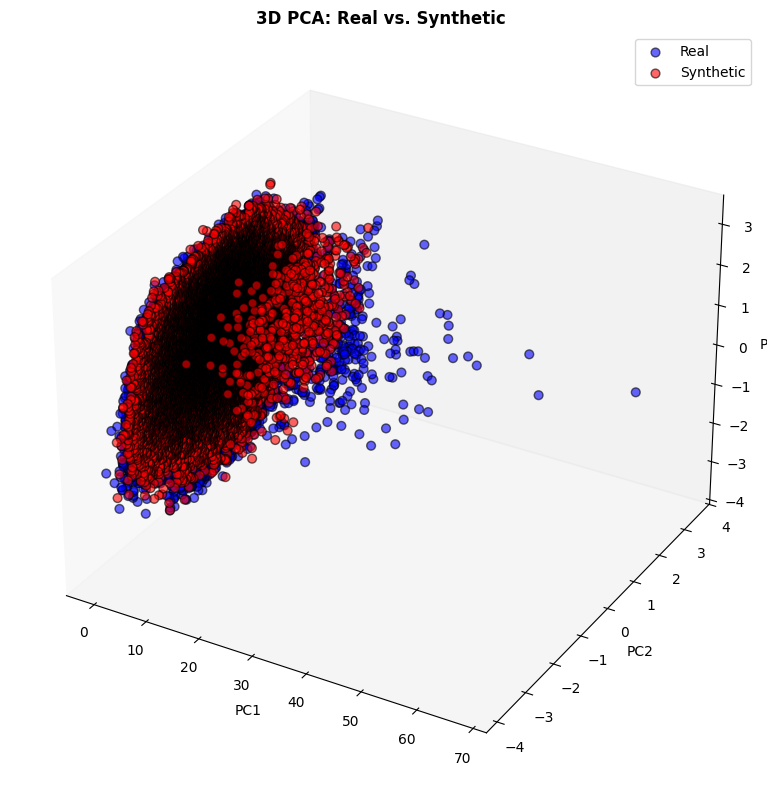

In [75]:
pca_visual_comparison_3d(X_train, synthetic_data)

In [76]:
#pca_visual_comparison(X_train, synthetic_data)


### UMAP Analysis

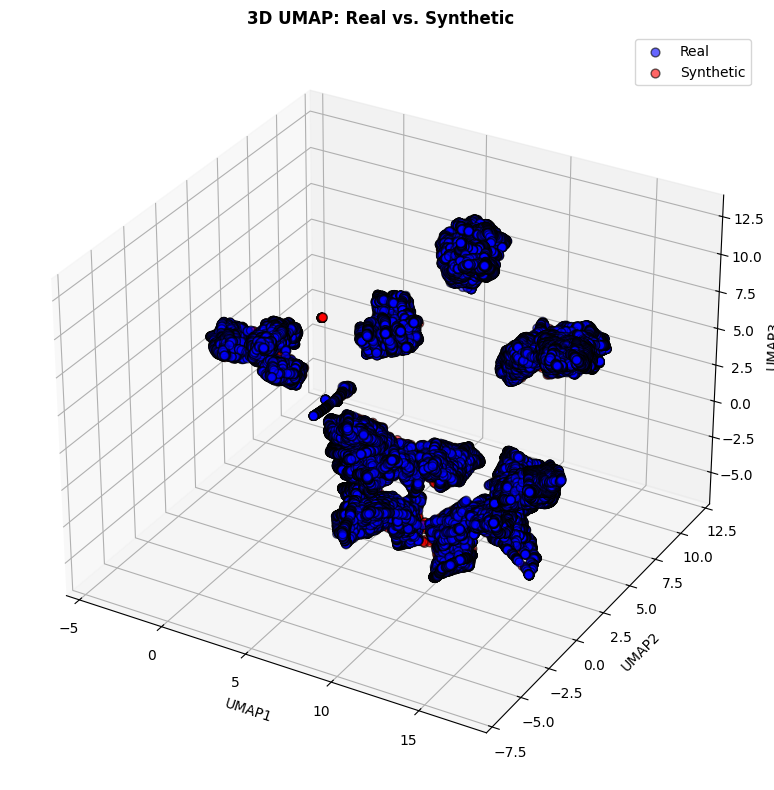

In [77]:
umap_visual_comparison_3d(X_train, synthetic_data)

In [78]:
#umap_visual_comparison(X_train, synthetic_data)


### GLM Frequency Analysis

In [79]:
# Baseline frequency model
results_frequency_3 = run_glm_frequency_analysis(X_train, X_test, label="Baseline")


Fold 1 Poisson Deviance Score: 0.2113
Fold 2 Poisson Deviance Score: 0.2744
Fold 3 Poisson Deviance Score: 0.3212
Fold 4 Poisson Deviance Score: 0.3262
Fold 5 Poisson Deviance Score: 0.2611
Average cross-validation Poisson Deviance Score: 0.2788
Standard Deviation of CV Scores: 0.0423
Train Poisson Deviance: 0.2788
Test Poisson Deviance: 0.4368


In [80]:
# Using synthetic sample data with exposure clipping
results_frequency_4 = run_glm_frequency_analysis(new_samples_df, X_test, clip_exposure=True, label="Synthetic Clipped")


Fold 1 Poisson Deviance Score: 1.0440
Fold 2 Poisson Deviance Score: 0.5223
Fold 3 Poisson Deviance Score: 0.2380
Fold 4 Poisson Deviance Score: 0.2512
Fold 5 Poisson Deviance Score: 0.2881
Average cross-validation Poisson Deviance Score: 0.4687
Standard Deviation of CV Scores: 0.3056
Train Poisson Deviance: 0.4686
Test Poisson Deviance: 0.4687


### GLM Cost Analysis

In [81]:
results_cost_3 = run_glm_cost_analysis(X_train, X_test)


Fold 1 Gamma Deviance Score: 1.8636
Fold 2 Gamma Deviance Score: 1.8794
Fold 3 Gamma Deviance Score: 1.6971
Fold 4 Gamma Deviance Score: 1.8394
Fold 5 Gamma Deviance Score: 1.8494
Average cross-validation Gamma Deviance Score: 1.825777294896016
Standard Deviation of CV Scores: 0.06574128033743543
Train Gamma Deviance: 1.7615
Test Gamma Deviance: 1.7251


In [82]:
results_cost_4 = run_glm_cost_analysis(new_samples_df, X_test, is_sampled=True)

Fold 1 Gamma Deviance Score: 1.2152
Fold 2 Gamma Deviance Score: 1.2333
Fold 3 Gamma Deviance Score: 1.2656
Fold 4 Gamma Deviance Score: 1.4506
Fold 5 Gamma Deviance Score: 0.9579
Average cross-validation Gamma Deviance Score: 1.2245287623496477
Standard Deviation of CV Scores: 0.157504736695796
Train Gamma Deviance: 1.2062
Test Gamma Deviance: 4.8291


### Feature Importance Analysis


--- SHAP Feature Importance for Frequency Model ---


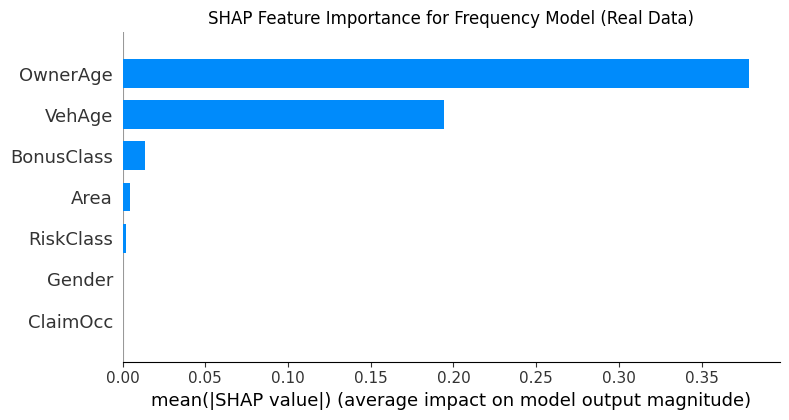


--- SHAP Feature Importance for Severity Model ---


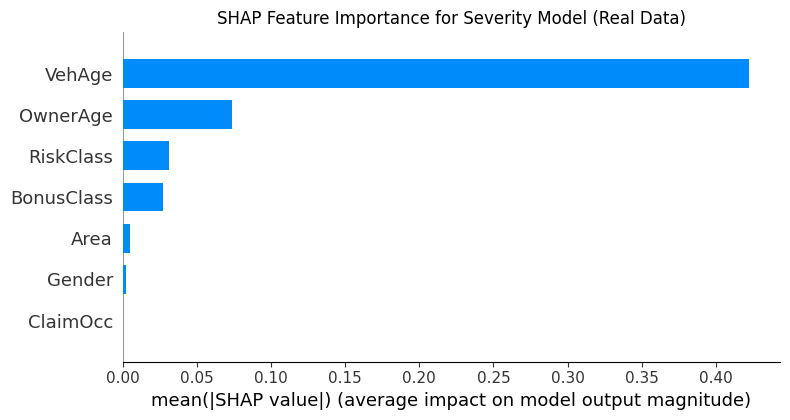

In [83]:
# --- SHAP Feature Importance for Frequency ---
print("\n--- SHAP Feature Importance for Frequency Model ---")

# Prepare data for frequency model SHAP
X_train_freq = X_train.drop(['Exposure', 'ClaimNb', 'ClaimAmount'], axis=1, errors='ignore')
y_train_freq = X_train['ClaimNb']
sample_weight_freq = X_train['Exposure']

X_test_freq = X_test.drop(['Exposure', 'ClaimNb', 'ClaimAmount'], axis=1, errors='ignore')

# Filter out rows with Exposure = 0 for frequency model training and SHAP explanation
# This step is crucial for consistency with how run_glm_frequency_analysis handles data
mask_train_freq = sample_weight_freq > 0
X_train_freq_filtered = X_train_freq[mask_train_freq]
y_train_freq_filtered = y_train_freq[mask_train_freq]
sample_weight_freq_filtered = sample_weight_freq[mask_train_freq]

# Ensure X_test_freq also only contains rows where Exposure > 0
# We need to apply the same mask to X_test to ensure `shap_values` is calculated on the same data.
# For SHAP, the `X_test` for explainer should correspond to the `X_test_` used in `run_glm_frequency_analysis`
mask_test_freq = X_test['Exposure'] > 0
X_test_freq_filtered = X_test_freq[mask_test_freq]


# Plot SHAP for Frequency
plot_glm_shap_importance(
    X_train=X_train_freq_filtered,
    X_test=X_test_freq_filtered,
    y_train=y_train_freq_filtered / sample_weight_freq_filtered, # Target is rate (ClaimNb / Exposure)
    sample_weight=sample_weight_freq_filtered,
    power=1, # Power=1 for Poisson (frequency)
    title="SHAP Feature Importance for Frequency Model (Real Data)",
    max_display=10
)

# --- SHAP Feature Importance for Severity ---
print("\n--- SHAP Feature Importance for Severity Model ---")

# Prepare data for severity model SHAP
X_train_cost_prep = X_train[X_train['ClaimAmount'] != 0].copy()
X_test_cost_prep = X_test[X_test['ClaimAmount'] != 0].copy()

X_train_sev = X_train_cost_prep.drop(columns=['Acost', 'Exposure', 'ClaimAmount', 'ClaimNb'], errors='ignore')
y_train_sev = X_train_cost_prep['ClaimAmount'] / X_train_cost_prep['ClaimNb']
sample_weight_sev = X_train_cost_prep['ClaimNb'] # Number of claims is the weight for severity

X_test_sev = X_test_cost_prep.drop(columns=['Acost', 'Exposure', 'ClaimAmount', 'ClaimNb'], errors='ignore')

# Plot SHAP for Severity
plot_glm_shap_importance(
    X_train=X_train_sev,
    X_test=X_test_sev,
    y_train=y_train_sev,
    sample_weight=sample_weight_sev,
    power=2, # Power=2 for Gamma (severity)
    title="SHAP Feature Importance for Severity Model (Real Data)",
    max_display=10
)


--- SHAP Feature Importance for Frequency Model (Synthetic Data) ---


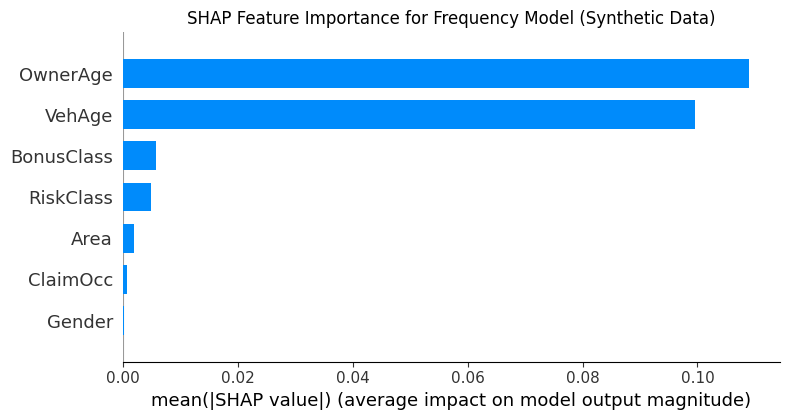


--- SHAP Feature Importance for Severity Model (Synthetic Data) ---


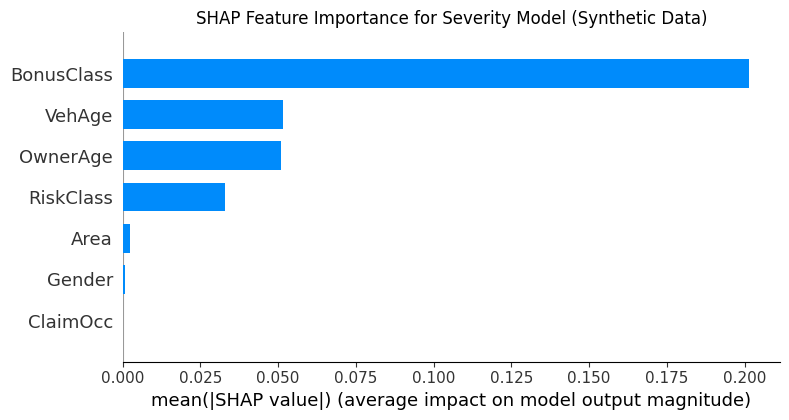

In [84]:
# --- SHAP Feature Importance for Frequency (Synthetic Data) ---
print("\n--- SHAP Feature Importance for Frequency Model (Synthetic Data) ---")

# Prepare data for frequency model SHAP using synthetic data
X_train_freq_synth = new_samples_df.drop(['Exposure', 'ClaimNb', 'ClaimAmount'], axis=1, errors='ignore')
y_train_freq_synth = new_samples_df['ClaimNb']
sample_weight_freq_synth = new_samples_df['Exposure']

# X_test_freq is the same as before (real test data)
X_test_freq = X_test.drop(['Exposure', 'ClaimNb', 'ClaimAmount'], axis=1, errors='ignore')

# Filter out rows with Exposure = 0 for frequency model training and SHAP explanation
mask_train_freq_synth = sample_weight_freq_synth > 0
X_train_freq_synth_filtered = X_train_freq_synth[mask_train_freq_synth]
y_train_freq_synth_filtered = y_train_freq_synth[mask_train_freq_synth]
sample_weight_freq_synth_filtered = sample_weight_freq_synth[mask_train_freq_synth]

# Ensure X_test_freq also only contains rows where Exposure > 0
mask_test_freq = X_test['Exposure'] > 0
X_test_freq_filtered = X_test_freq[mask_test_freq]

# Plot SHAP for Frequency (Synthetic Data)
plot_glm_shap_importance(
    X_train=X_train_freq_synth_filtered,
    X_test=X_test_freq_filtered,
    y_train=y_train_freq_synth_filtered / sample_weight_freq_synth_filtered, # Target is rate
    sample_weight=sample_weight_freq_synth_filtered,
    power=1, # Power=1 for Poisson (frequency)
    title="SHAP Feature Importance for Frequency Model (Synthetic Data)",
    max_display=10
)

# --- SHAP Feature Importance for Severity (Synthetic Data) ---
print("\n--- SHAP Feature Importance for Severity Model (Synthetic Data) ---")

# Prepare data for severity model SHAP using synthetic data
X_train_cost_prep_synth = new_samples_df[new_samples_df['ClaimAmount'] != 0].copy()
X_test_cost_prep_synth = X_test[X_test['ClaimAmount'] != 0].copy() # Keep using real test data for explanation

X_train_sev_synth = X_train_cost_prep_synth.drop(columns=['Acost', 'Exposure', 'ClaimAmount', 'ClaimNb'], errors='ignore')
y_train_sev_synth = X_train_cost_prep_synth['ClaimAmount'] / X_train_cost_prep_synth['ClaimNb']
sample_weight_sev_synth = X_train_cost_prep_synth['ClaimNb'] # Number of claims is the weight for severity

X_test_sev_synth = X_test_cost_prep_synth.drop(columns=['Acost', 'Exposure', 'ClaimAmount', 'ClaimNb'], errors='ignore')


# Plot SHAP for Severity (Synthetic Data)
plot_glm_shap_importance(
    X_train=X_train_sev_synth,
    X_test=X_test_sev_synth,
    y_train=y_train_sev_synth,
    sample_weight=sample_weight_sev_synth,
    power=2, # Power=2 for Gamma (severity)
    title="SHAP Feature Importance for Severity Model (Synthetic Data)",
    max_display=10
)

### Results

In [85]:
# The dictionary dataset 1
metrics_dict_1 = results_frequency_1[1]
mpd_train_1 = metrics_dict_1['mpd_train']
mpd_test_1 = metrics_dict_1['mpd_test']
print(f"mpd_train_1: {mpd_train_1}")
print(f"mpd_test_1: {mpd_test_1}")

mpd_train_1: 1.4344568519034897
mpd_test_1: 1.741190103494106


In [86]:
# The dictionary synthetic dataset 1
metrics_dict_2 = results_frequency_2[1]
mpd_train_2 = metrics_dict_2['mpd_train']
mpd_test_2 = metrics_dict_2['mpd_test']
print(f"mpd_train_2: {mpd_train_2}")
print(f"mpd_test_2: {mpd_test_2}")

mpd_train_2: 2.711737103209519
mpd_test_2: 1.742280685598908


In [87]:
# The dictionary dataset 2
metrics_dict_3 = results_frequency_3[1]
mpd_train_3 = metrics_dict_3['mpd_train']
mpd_test_3 = metrics_dict_3['mpd_test']
print(f"mpd_train_3: {mpd_train_3}")
print(f"mpd_test_3: {mpd_test_3}")

mpd_train_3: 0.2787767739809314
mpd_test_3: 0.4367935890535355


In [88]:
# The dictionary synthetic dataset 2
metrics_dict_4 = results_frequency_4[1]
mpd_train_4 = metrics_dict_4['mpd_train']
mpd_test_4 = metrics_dict_4['mpd_test']
print(f"mpd_train_4: {mpd_train_4}")
print(f"mpd_test_4: {mpd_test_4}")

mpd_train_4: 0.46860580356582743
mpd_test_4: 0.4686877972707727


In [89]:
# The dictionary dataset 1
mgd_train_1 = results_cost_1['mgd_train']
mgd_test_1 = results_cost_1['mgd_test']
print(f"mgd_train_1: {mgd_train_1}")
print(f"mgd_test_1: {mgd_test_1}")

mgd_train_1: 1.5508741472884893
mgd_test_1: 1.7221300040077396


In [90]:
# The dictionary synthetic dataset 1
mgd_train_2 = results_cost_2['mgd_train']
mgd_test_2 = results_cost_2['mgd_test']
print(f"mgd_train_2: {mgd_train_2}")
print(f"mgd_test_2: {mgd_test_2}")

mgd_train_2: 1.0873665126342127
mgd_test_2: 2.176369346452452


In [91]:
# The dictionary dataset 2
mgd_train_3 = results_cost_3['mgd_train']
mgd_test_3 = results_cost_3['mgd_test']
print(f"mgd_train_3: {mgd_train_3}")
print(f"mgd_test_3: {mgd_test_3}")

mgd_train_3: 1.7615204909151378
mgd_test_3: 1.7250831816188326


In [92]:
# The dictionary synthetic dataset 2
mgd_train_4 = results_cost_4['mgd_train']
mgd_test_4 = results_cost_4['mgd_test']
print(f"mgd_train_4: {mgd_train_4}")
print(f"mgd_test_4: {mgd_test_4}")

mgd_train_4: 1.2061517691012547
mgd_test_4: 4.829080959718717


In [93]:
# Create the DataFrame
results_df1 = {
    'mpd_train': mpd_train_1,
    'mpd_test': mpd_test_1,
    'mgd_train': mgd_train_1,
    'mgd_test': mgd_test_1,
}
results_df2 = {
    'mpd_train': mpd_train_2,
    'mpd_test': mpd_test_2,
    'mgd_train': mgd_train_2,
    'mgd_test': mgd_test_2,
}
results_df3 = {
    'mpd_train': mpd_train_3,
    'mpd_test': mpd_test_3,
    'mgd_train': mgd_train_3,
    'mgd_test': mgd_test_3,
}
results_df4 = {
    'mpd_train': mpd_train_4,
    'mpd_test': mpd_test_4,
    'mgd_train': mgd_train_4,
    'mgd_test': mgd_test_4,
}
d1=pd.DataFrame(results_df1, index=['dataset 1'])
d2=pd.DataFrame(results_df2, index=['synthetic dataset 1'])
d3=pd.DataFrame(results_df3, index=['dataset 2'])
d4=pd.DataFrame(results_df4, index=['synthetic dataset 2'])
df_tot= pd.concat([d1,d2,d3,d4])
df_tot

,mpd_train,mpd_test,mgd_train,mgd_test
dataset 1,1.434457,1.741190,1.550874,1.722130
synthetic dataset 1,2.711737,1.742281,1.087367,2.176369
dataset 2,0.278777,0.436794,1.761520,1.725083
synthetic dataset 2,0.468606,0.468688,1.206152,4.829081


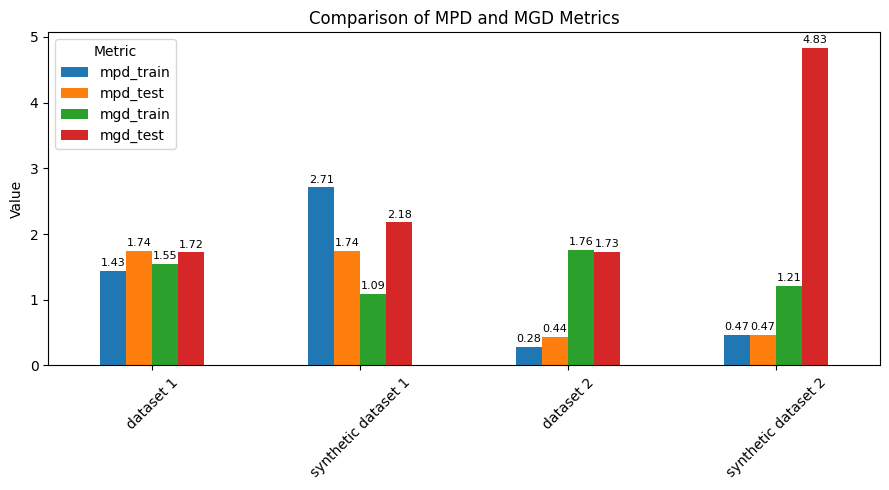

In [94]:
# Set up the plot
ax = df_tot.plot(kind='bar', figsize=(9, 5))

# Labels and title
plt.title('Comparison of MPD and MGD Metrics')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.legend(title='Metric')

# Add value labels with smaller font size
for container in ax.containers:
    labels = ax.bar_label(container, fmt='%.2f', label_type='edge', padding=2)
    for label in labels:
        label.set_fontsize(8)

plt.tight_layout()
plt.show()

